In [1]:
from functools import partial
from pathlib import Path
from turtle import color
from setuptools_scm import meta
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sbi.inference import simulate_for_sbi
from hnpe.misc import make_label
from hnpe.posterior import build_flow, IdentityJRNMM, get_posterior
from hnpe.simulator import prior_JRNMM, simulator_JRNMM, get_ground_truth
from hnpe.summary import summary_JRNMM
from hnpe.plot import plot_pairgrid_with_groundtruth

from diagnostics.pp_plots import multi_cde_pit_values, PP_plot_1D, sbc_plot, confidence_region_null
from diagnostics.multi_local_test import multivariate_lct, get_lct_results, compute_test_statistic
from diagnostics.hpd_coverage import highest_density_level, highest_density
from diagnostics.localPIT_regression import local_correlation_regression, localPIT_regression_baseline
from data.feature_transforms import identity

import tqdm as tqdm


## SBI Task: Inference of the JR-NMM parameters under uniform prior


- Prior: `torch.Size([1, 4])`
    $$p(\theta) = \mathcal{U}([10,250], [50,500], [100,5000],[-20,20])$$
- Simualtor (JR-NMM): `torch.Size([1, 1024])`
    $$x \sim \text{Simulator}(\theta) \approx p(x\mid \theta) \text{, where} \theta = (C, \mu, \sigma, g)$$
- Summary Statistics (Fourier log Power Spectral Density): `torch.Size([1, 33])`
    $$s(x) = \text{log-PSD}(x)$$

**Goal:** estimate $p(\theta\mid x_0)$ with a Normalizing Flow $q_{\phi}(\theta \mid s(x_0))$ with $x_0$ an observation genreated from ground-truth parameters $\theta_0 = (C_0, \mu_0, \sigma_0, g_0)$.

### Experimental SETUP

#### Global Variables

In [2]:
# PATH
PATH_EXPERIMENT = 'saved_experiments/JR-NMM/'

# DATASETS
B = 50_000 # train flow
B_PRIME = 10_000 # train local pit regressors 
B_DOUBLE_PRIME = 1_000 # evaluate 
N_SAMPLES_POSTERIOR = 10_000

# DATA FEATURES
N_EXTRA = 0
SINGLE_REC = False
# ground-truth gain parameter
GT_GAIN = 0

# MODEL FEATURES
NAIVE = True  # use NAIVE OR HNPE
METHOD = 'naive'*NAIVE + 'hnpe'*(1-NAIVE)

#### Meta-parameters

In [3]:
meta_parameters = {}
# Data features
meta_parameters['t_recording'] = 8
meta_parameters['n_extra'] = N_EXTRA
# Summary Features
meta_parameters["summary"] = "Fourier"
meta_parameters["n_sf"] = 33
# Training Features
meta_parameters["n_rd"] = 1  # amortized flow
meta_parameters["n_sr"] = B  # simulations per round

# example cases we are considering here
meta_parameters["case"] = PATH_EXPERIMENT+"Flows_amortized/JRNMM_nextra_{:02}_" \
                "naive_{}_" \
                "single_rec_{}".format(N_EXTRA,
                                    NAIVE,
                                    SINGLE_REC)

# label for saving directory of experiments
meta_parameters["label"] = make_label(meta_parameters)
folderpath = Path.cwd() / meta_parameters["label"]


#### Prior, Simulator and Summary Statistics

In [4]:
# Prior
prior = prior_JRNMM(parameters=[('C', 10.0, 250.0),
                                ('mu', 50.0, 500.0),
                                ('sigma', 100.0, 5000.0),
                                ('gain', -20.0, +20.0)])

# Simulator
simulator = partial(simulator_JRNMM,
                    input_parameters=['C', 'mu', 'sigma', 'gain'],
                    t_recording=meta_parameters['t_recording'],
                    n_extra=N_EXTRA,
                    p_gain=prior,
                    single_recording=False)  

# Summary features
summary_extractor = summary_JRNMM(n_extra=N_EXTRA,
                            d_embedding=meta_parameters['n_sf'],
                            n_time_samples=int(128*meta_parameters['t_recording']),
                            type_embedding=meta_parameters['summary'])
summary_extractor.embedding.net.logscale = True  # log-PSD         

### Load trained Estimator
In what follows, the estimator will try to approximate the posterior $p(\theta \mid x_0)$ with samples from the joint $(x_i, \theta_i) \sim p(x\mid \theta_i)p(\theta_i)$. 
the estimator actually trains on the summary statisctics of the time series $x_i = \text{Summary}(\text{Simulator}(\theta_i))$. 

In [5]:
filename = PATH_EXPERIMENT+f'posteriors_amortized/{METHOD}_posterior_nextra_{N_EXTRA}_single_rec_{SINGLE_REC}_nsim_{B}.pkl'
if os.path.exists(filename):
        posterior = torch.load(filename)
else: 
    # choose a function which creates a neural network density estimator
    build_nn_posterior = partial(build_flow, 
                                embedding_net=IdentityJRNMM(),
                                naive=NAIVE,
                                aggregate=True,
                                z_score_theta=True,
                                z_score_x=True,
                                n_layers=5)  

    # get posterior 
    posterior = get_posterior(
        simulator, prior, summary_extractor, build_nn_posterior,
        meta_parameters, round_=0, path='saved_experiments/JR-NMM/Flows_amortized_new/JRNMM_nextra_00_trec_8naive_True_single_rec_False_n_layers_5/Fourier_n_rd_1_n_sr_50000_n_sf_33/'
    )
    torch.save(posterior, filename)

# Validation

### Dataset generation

In [6]:
# Simulate Data, create datasets
filename = PATH_EXPERIMENT + f"datasets_{METHOD}.pkl"

if os.path.exists(filename):
    datasets = torch.load(filename)
else:
    # b_theta, b_x = data_gen.get_joint_data(B)
    b_prime_theta, b_prime_x = simulate_for_sbi(
        simulator=simulator, proposal=prior, num_simulations=B_PRIME
    )
    b_prime_x = summary_extractor(b_prime_x)
    b_double_prime_theta, b_double_prime_x = simulate_for_sbi(
        simulator=simulator, proposal=prior, num_simulations=B_DOUBLE_PRIME
    )
    b_double_prime_x = summary_extractor(b_double_prime_x)

    datasets = {
        # "B": {"theta": b_theta, "x": b_x},
        "B_prime": {"theta": b_prime_theta, "x": b_prime_x},
        "B_double_prime": {"theta": b_double_prime_theta, "x": b_double_prime_x},
    }
    torch.save(datasets, filename)

datasets['B_prime']['theta'].shape, datasets['B_prime']['x'].shape
datasets['B_double_prime']['theta'] = datasets['B_double_prime']['theta'][:1000]
datasets['B_double_prime']['x'] = datasets['B_double_prime']['x'][:1000]

datasets['B_double_prime']['theta'].shape, datasets['B_double_prime']['x'].shape


(torch.Size([1000, 4]), torch.Size([1000, 33, 1]))

#### Recover order via Permutations

In [7]:
theta_new = datasets['B_prime']['theta'][:1]
print(theta_new)
for i in range(10):
    theta_new = posterior._flow._transform._transforms[1]._transforms[i]._transforms[1](theta_new)[0]
    print(theta_new)

def apply_permutations(list):
    list_new = []
    permuted_ids = [2,3,1,0]
    for pi in permuted_ids:
        list_new.append(list[pi])
    return list_new

def apply_inv_permutations(list):
    list_new = []
    permuted_ids = [3,2,0,1]
    for pi in permuted_ids:
        list_new.append(list[pi])
    return list_new

tensor([[ 104.0939,   98.6300, 3300.2747,  -18.1834]])
tensor([[ -18.1834, 3300.2747,   98.6300,  104.0939]])
tensor([[ -18.1834,  104.0939, 3300.2747,   98.6300]])
tensor([[  98.6300, 3300.2747,  -18.1834,  104.0939]])
tensor([[  98.6300, 3300.2747,  104.0939,  -18.1834]])
tensor([[3300.2747,   98.6300,  104.0939,  -18.1834]])
tensor([[  98.6300, 3300.2747,  -18.1834,  104.0939]])
tensor([[ 104.0939, 3300.2747,  -18.1834,   98.6300]])
tensor([[ 104.0939,  -18.1834, 3300.2747,   98.6300]])
tensor([[3300.2747,   98.6300,  -18.1834,  104.0939]])
tensor([[3300.2747,  -18.1834,   98.6300,  104.0939]])


In [8]:
param_names = [r'$\theta_1 = C$', r'$\theta_2 = \mu$', r'$\theta_3 = \sigma$', r'$\theta_4 = g$']
colors=['orange', 'red', 'purple', 'blue']

param_names_permuted = apply_permutations(param_names)
colors_permuted = apply_permutations(colors)

## Global COVERAGE for multivariate density NPEs: Global PIT vs. SBC vs. HPD
We show the global PIT-distribution for the JR-NMM NPE for which correlations play an important role. We can see that there is a problem in two dimensions (the estimator is biased). We will apply the 1D local coverage test [Zhao et al.] on each dimension to get more insight on the behavior of the estimator.

### PP-plots

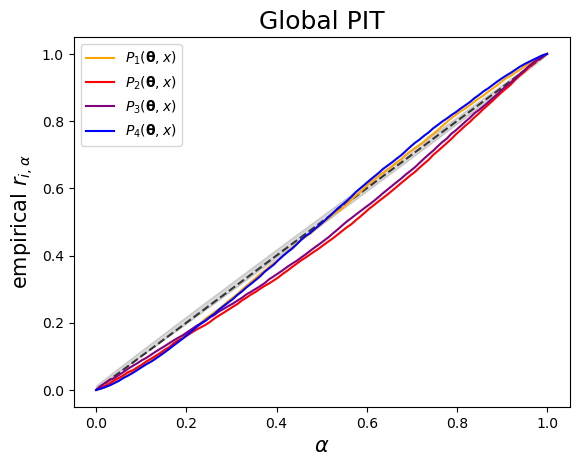

In [9]:
# PLOT EXPECTED PIT-DISTRIBUTION of the trained estimators
theta_test, x_test = datasets['B_prime']['theta'], datasets['B_prime']['x']

# Compute PIT-values of the flows 
# [PIT(Theta_i, X_i, maf_good) = F_{Q_good|X_i}(Theta_i)
flow_joint_pit_values = multi_cde_pit_values(
    theta_test, x_test, posterior, feature_transform=identity
)
flow_joint_pit_values = [flow_joint_pit_values[i] for i in range(4)]

flow_joint_pit_values_permuted = apply_inv_permutations(flow_joint_pit_values)

# PP-plot of expected PIT-distribution 
# r_alpha = [P_X,Theta(Z < alpha)]
PP_plot_1D(
    PIT_values=flow_joint_pit_values,
    alphas=np.linspace(0, 1, 100),
    colors=colors,
    labels=[r'$P_1(\mathbf{\theta},x)$', r'$P_2(\mathbf{\theta},x)$', r'$P_3(\mathbf{\theta},x)$', r'$P_4(\mathbf{\theta},x)$'],
    title="Global PIT",
    ylabel=r"empirical $r_{i,\alpha}$",
    confidence_int = True,
    conf_alpha=0.05/4, # bonferonni correction
)

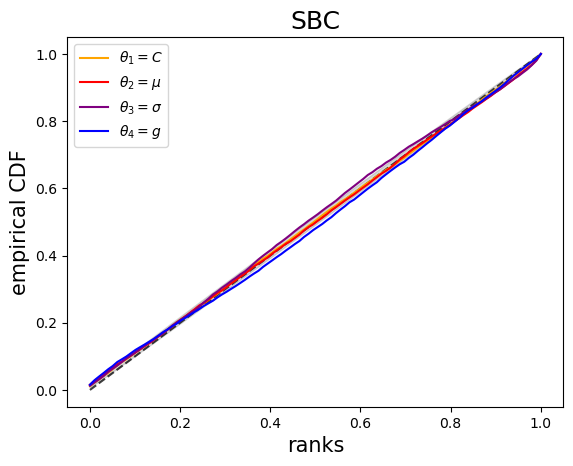

In [10]:
from sbi.analysis.sbc import run_sbc
from sbi.inference.posteriors.direct_posterior import DirectPosterior
# posterior_sbc = DirectPosterior(posterior_estimator=posterior, prior=prior,
#         x_shape=datasets['B_prime']['x'][0][None, :].shape)

# sbc = run_sbc(datasets['B_prime']['theta'], datasets['B_prime']['x'][:,None,:,:], posterior=posterior_sbc)
# torch.save(sbc, PATH_EXPERIMENT+'sbc_prime.pkl')

sbc_ranks = np.array(torch.load(PATH_EXPERIMENT+'sbc_prime.pkl')[0])
colors=colors
labels = param_names
sbc_plot(sbc_ranks, colors=colors, labels=labels, conf_alpha=0.05/4) # bonferonni correction

In [13]:
if os.path.exists(PATH_EXPERIMENT+'hpd_ranks.pkl'):
    hpd_values = torch.load(PATH_EXPERIMENT+'hpd_ranks.pkl')
else:
    hpd_values, alphas = highest_density(posterior, theta_test, x_test)
    torch.save(hpd_values, PATH_EXPERIMENT+'hpd_ranks.pkl')

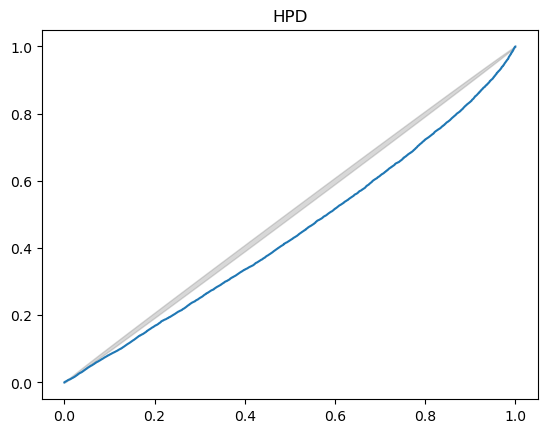

In [12]:
alphas = torch.linspace(0.0, 1.0, len(hpd_values))

confidence_region_null(alphas, N=B_PRIME, conf_alpha=0.05)
plt.plot(alphas, hpd_values)
plt.title("HPD")
plt.show()

### Mutual independance: correlation coefficient

In [12]:
df_flow_transform = pd.DataFrame({
'Z_1': posterior._transform(theta_test, context=x_test)[0][:, 0].detach().numpy(),
'Z_2' : posterior._transform(theta_test, context=x_test)[0][:, 1].detach().numpy(),
'Z_3' : posterior._transform(theta_test, context=x_test)[0][:, 2].detach().numpy(),
'Z_4' : posterior._transform(theta_test, context=x_test)[0][:, 3].detach().numpy()
})
corr_12 = df_flow_transform.corr()['Z_1'][1]
corr_13 = df_flow_transform.corr()['Z_1'][2]
corr_14 = df_flow_transform.corr()['Z_1'][3]
corr_23 = df_flow_transform.corr()['Z_2'][2]
corr_24 = df_flow_transform.corr()['Z_2'][3]
corr_34 = df_flow_transform.corr()['Z_3'][3]
df_flow_transform.corr()

,Z_1,Z_2,Z_3,Z_4
Z_1,1.000000,-0.039795,-0.027077,0.007374
Z_2,-0.039795,1.000000,0.016211,-0.001493
Z_3,-0.027077,0.016211,1.000000,0.015652
Z_4,0.007374,-0.001493,0.015652,1.000000


In [13]:
# null hypothesis
from scipy.stats import norm

n_trials = 1000

corr_null = []
null_df_list = []
for t in range(n_trials):
    null_df_list.append(pd.DataFrame({
        'Z_1': norm().rvs(B_PRIME),
        'Z_2': norm().rvs(B_PRIME),
    }))
    corr_null.append(null_df_list[-1].corr()['Z_1'][1])

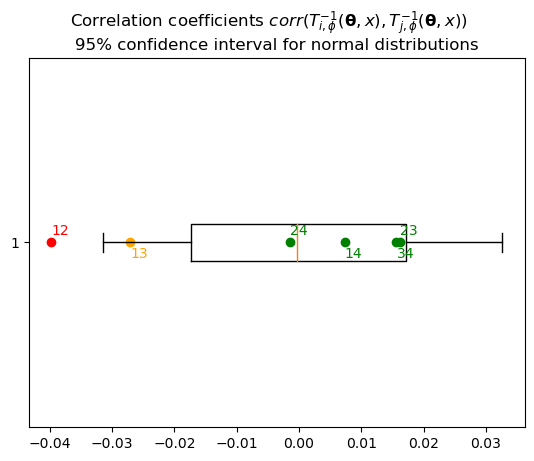

In [15]:
import matplotlib.cbook as cbook

data = corr_null
stats = cbook.boxplot_stats(data)[0]
stats['q1'] = np.quantile(data, 0.05)
stats['q3'] = np.quantile(data, 0.95)
stats['whislo'] = min(data)
stats['whishi'] = max(data)

fig, ax = plt.subplots(1, 1)
bp = ax.bxp([stats],widths=0.1, vert=False, showfliers=False,)
plt.text(corr_12, 1.02, '12', color='red')
plt.scatter(corr_12, 1, color='red')
plt.text(corr_13, 0.96, '13', color='orange')
plt.scatter(corr_13, 1, color='orange')
plt.text(corr_14, 0.96, '14', color='green')
plt.scatter(corr_14, 1, color='green')
plt.text(corr_23, 1.02, '23', color='green')
plt.scatter(corr_23, 1, color='green')
plt.text(corr_24, 1.02, '24', color='green')
plt.scatter(corr_24, 1, color='green')
plt.text(corr_34, 0.96, '34', color='green')
plt.scatter(corr_34, 1, color='green')

# plt.legend()
plt.title('95% confidence interval for normal distributions')
plt.suptitle(r'Correlation coefficients $corr(T_{i,\phi}^{-1}(\mathbf{\theta}, x),T_{j,\phi}^{-1}(\mathbf{\theta}, x))$')
plt.show()

In [17]:
np.linalg.eig(df_flow_transform.corr())

(array([1.05661129, 0.95627253, 1.01032891, 0.97678727]),
 array([[ 0.64310524, -0.73768381, -0.20154122,  0.04024153],
        [-0.59043259, -0.5380349 ,  0.19866883,  0.56783668],
        [-0.4863851 , -0.33866197, -0.44632175, -0.67047334],
        [-0.03513595,  0.22726441, -0.84894566,  0.4758231 ]]))

### Neurips images

In [11]:
# colors_sbc = ['#95BF74', '#519F54', '#417448', '#31493C']
# colors_sbc = ['#FFCAD4', '#F4ACB7', '#AC5F7B', '#64113F']
colors_sbc = ['#B9D6AF', '#B2C695', '#81B598', '#519D7A']
# colors_pit = ['#3BCEAC','#FFD23F','#EE4266','#540D6E']
colors_pit = ['#C095EE','#FFD23F','#EE4266','#540D6E']

labels_sbc = [r'$\theta_1 = C$', r'$\theta_2 = \mu$', r'$\theta_3 = \sigma$', r'$\theta_4 = g$']
labels_pit = [r'$P_{1}(\mathbf{\theta})$', r'$P_{2}(\mathbf{\theta})$', r'$P_{3}(\mathbf{\theta})$', r'$P_{4}(\mathbf{\theta})$']

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman


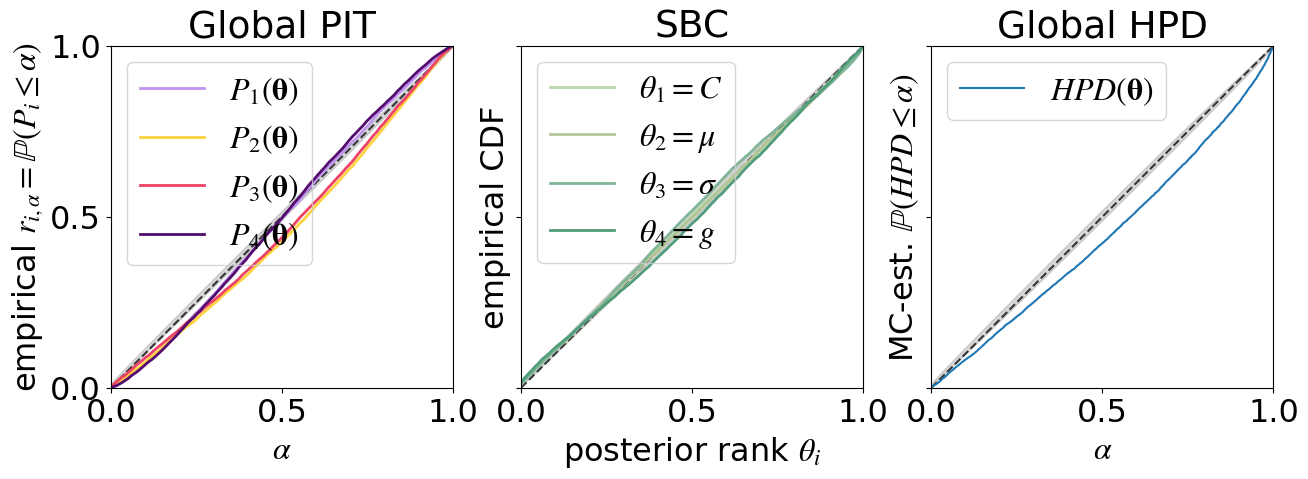

In [14]:
from plots_neurips2022 import multi_global_consistency

fig = multi_global_consistency(multi_PIT_values=flow_joint_pit_values,
    alphas=np.linspace(0, 1, 100),
    colors_sbc=colors_sbc,
    colors_pit=colors_pit,
    labels_sbc=labels_sbc,
    labels_pit = labels_pit,
    sbc_ranks=sbc_ranks,
    hpd_values=hpd_values
    )


# plt.savefig(PATH_EXPERIMENT+'images_neurips/global_consistency.pdf')

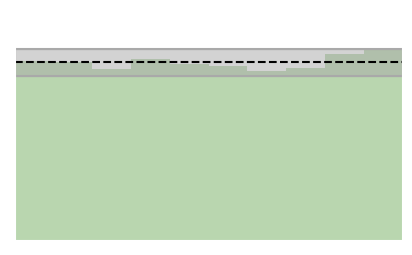

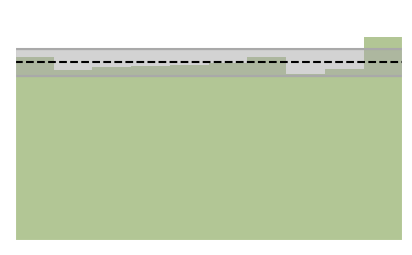

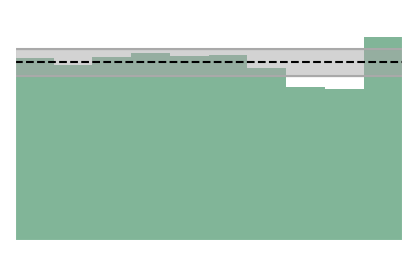

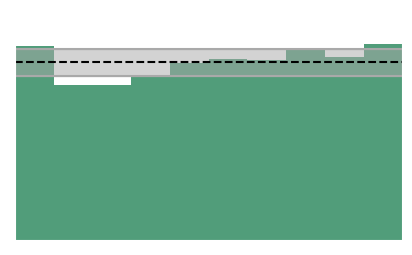

In [15]:
from plots_neurips2022 import global_histograms
for i in range(4):
    fig = global_histograms(sbc_ranks[:,i]/1000, color=colors_sbc[i], conf_alpha=0.05/4) # bonferonni correction
    plt.savefig(PATH_EXPERIMENT+f'images_neurips/hist_SBC_dim{i}.pdf')
    plt.show()

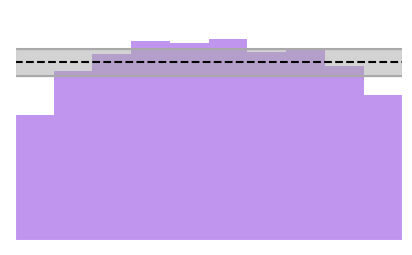

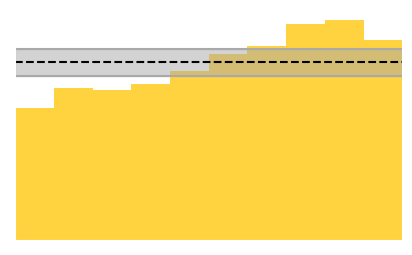

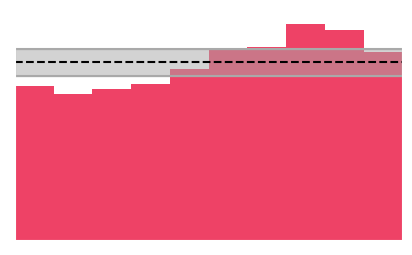

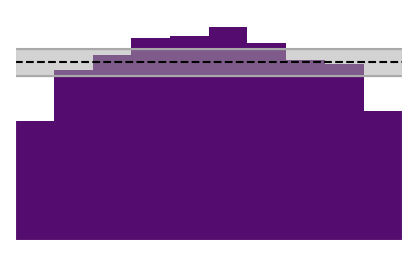

In [16]:
from plots_neurips2022 import global_histograms
for i in range(4):
    fig = global_histograms(flow_joint_pit_values[i], color=colors_pit[i], conf_alpha=0.05/4) # bonferonni correction
    plt.savefig(PATH_EXPERIMENT+f'images_neurips/hist_globalPIT_dim{i}.pdf')
    plt.show()

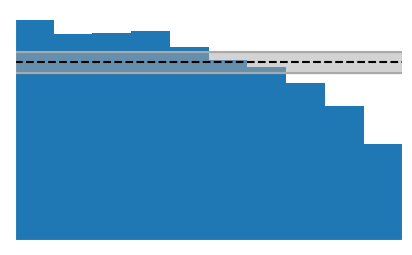

In [17]:
from plots_neurips2022 import global_histograms

fig = global_histograms(np.array(hpd_values).ravel(), color='#1f77b4', conf_alpha=0.05)
# plt.savefig(PATH_EXPERIMENT+f'images_neurips/hist_globalHPD.pdf')
plt.show()

## LOCAL COVERAGE: Images for NeurIPS Workshop

### Ground-truth parameters and observation

We know that the parameters $(\mu, \sigma)$ and $g$ are coupled.

We thus choose to analyse the behavior of the estimator on a 1D cut through the parameter space, i.e. at different $x_0 = \text{Simulator}(C_0, \mu_0, \sigma_0, g_0)$ where $C_0, \mu_0, \sigma_0$ are fixed and we only vary the gain parameter $g_0 \in [-20,20]$.

**Intuition:** The average gain value is $\sum_{g=-20}^{20} g = 0$. We expect a consistent estimator at $g_0 = 0$, as the estimator is trained to maximize the ***average*** log-likelihood. If this is true, we would expect inconsistent behavior at $g_0 \neq 0$, because the estimator is globally biased for $(\mu, \sigma)$.

In [18]:
# ground-truth parameters to generate observation
# fixed_params
c = 135.0
mu = 220.0 
sigma = 2000.0
# different gain values 
gain_list = np.linspace(-20,20,9)

# theta_true_list = []

# x_obs_list = []
# for g in gain_list:
#     theta_true = torch.FloatTensor([c, mu, sigma, g])
#     meta_parameters['theta'] = theta_true
#     theta_true_list.append(theta_true)

#     ground_truth = get_ground_truth(meta_parameters,
#                                 input_parameters=['C', 'mu', 'sigma', 'gain'],
#                                 p_gain=prior, single_recording=SINGLE_REC)
#     ground_truth['observation'] = summary_extractor(ground_truth['observation'])
#     x_obs = ground_truth['observation'] # torch.Size([1, 33, n_extra+1])
#     x_obs_list.append(x_obs)
# # torch.save([theta_true, torch.stack(x_obs_list)[:,0,:,:]], PATH_EXPERIMENT+'gt_observations/nextra_0/gain_experiment_new.pkl')

x_obs_list = torch.load(PATH_EXPERIMENT+'gt_observations/nextra_0/gain_experiment_new.pkl')[1]
theta_obs_list = torch.load(PATH_EXPERIMENT+'gt_observations/nextra_0/gain_experiment_new.pkl')[0]
x_obs_list.shape


torch.Size([11, 33, 1])

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman


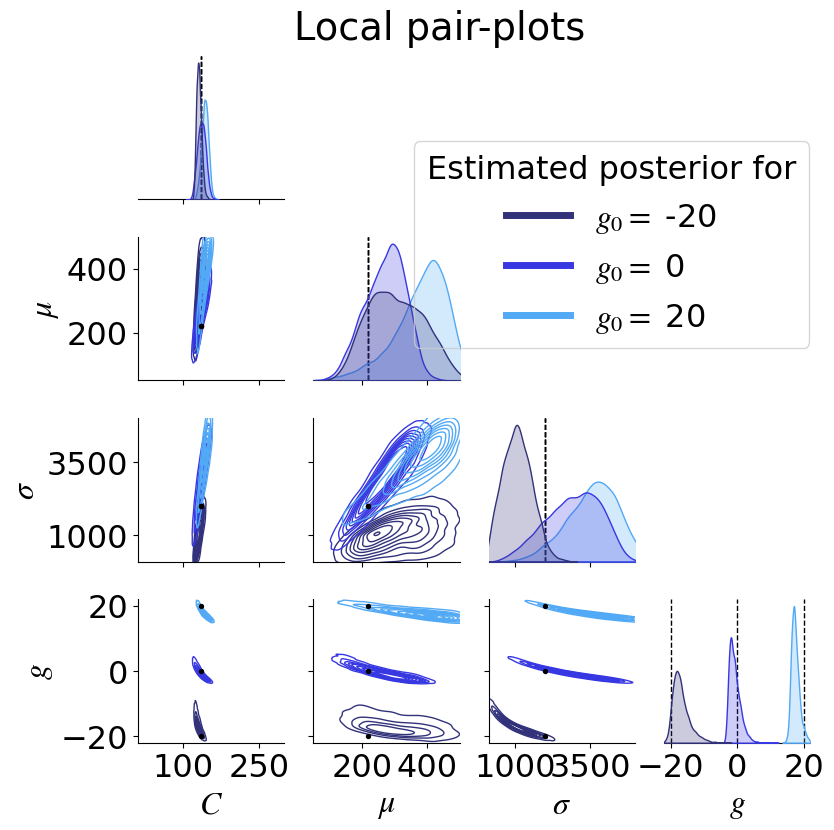

In [33]:
from plots_neurips2022 import plot_pairgrid_with_groundtruth

# Plot learned posteriors with true parameters 
cases = [{'method': METHOD, 'n_extra': N_EXTRA, 'gt_gain': -20, 'xobs_id': 1, 'n_sim': B,'single_rec': SINGLE_REC},
    # {'method': METHOD, 'n_extra': N_EXTRA, 'gt_gain': -15, 'xobs_id': 2, 'n_sim': B,'single_rec': SINGLE_REC},
    {'method': METHOD, 'n_extra': N_EXTRA, 'gt_gain': 0, 'xobs_id': 5, 'n_sim': B,'single_rec': SINGLE_REC},
    # {'method': METHOD, 'n_extra': N_EXTRA, 'gt_gain': 15, 'xobs_id': 8, 'n_sim': B,'single_rec': SINGLE_REC},]
    {'method': METHOD, 'n_extra': N_EXTRA, 'gt_gain': 20, 'xobs_id': 9, 'n_sim': B,'single_rec': SINGLE_REC},]

posteriors = {}
context = {}
theta_true_list = []
for exp in cases:
    # filename_posterior = PATH_EXPERIMENT+f"posteriors_amortized/naive_posterior_nextra_{exp['n_extra']}_single_rec_{exp['single_rec']}_nsim_{exp['n_sim']}.pkl"
    # filename_xobs = PATH_EXPERIMENT+f"gt_observations/nextra_{exp['n_extra']}/gt_observation_gain_{exp['gt_gain']}_new.pkl"
    if exp['n_extra'] > 0:
        filename_xobs = filename[:-4]+f"_single_rec_{exp['single_rec']}.pkl"
    
    label = r"$g_0 =$"+f" {exp['gt_gain']}"
    posteriors[label]= posterior #torch.load(filename_posterior)
    # context[label] = torch.load(filename_xobs)
    context[label] = x_obs_list[exp['xobs_id']][None,:,:]
    theta_true_list.append(np.array([c, mu, sigma, exp['gt_gain']])) 

color_dict = dict(zip(list(posteriors.keys()), ['#32327B', '#3838E2', '#52A9F5']))
# color_dict = dict(zip(list(posteriors.keys()), ['blue','purple', '#D90368', '#FFA500','gold']))

g = plot_pairgrid_with_groundtruth(
    posteriors=posteriors,
    context = context,
    theta_gt=theta_true_list,
    color_dict=color_dict,
    handles=[
        plt.Line2D([], [], color=color_dict[label], linewidth=5, label=label) for label in list(posteriors.keys())
    ],
    n_samples=N_SAMPLES_POSTERIOR,
    title = r'Estimated posterior for'
)

g.savefig(PATH_EXPERIMENT+'images_neurips/parigrid.pdf')

## Baseline Regression Results 

In [19]:
path_lct = PATH_EXPERIMENT + f"lct_results/naive_nextra_{N_EXTRA}_nsim_{B}/gain/"

path_lct_base_t1000_na100 = (
    path_lct + f"baseline/lct_results_baseline_mlp_nalpha_100_ntrials_{100}_n_alphas_{100}"
)  # no pvalues, used to compute Test statistic and pp-pplot

gain_list = np.linspace(-20, 20, 9, dtype=int)

lct_base_t1000_na100_path_list = []

for g in gain_list:
    lct_base_t1000_na100_path_list.append(path_lct_base_t1000_na100 + f"_gain_{g}.pkl")

from diagnostics.multi_local_test import get_lct_results

df_base_na100 = get_lct_results(lct_base_t1000_na100_path_list, pvalues=False)
df_base_na100.index = gain_list

### Test Statistic 

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman


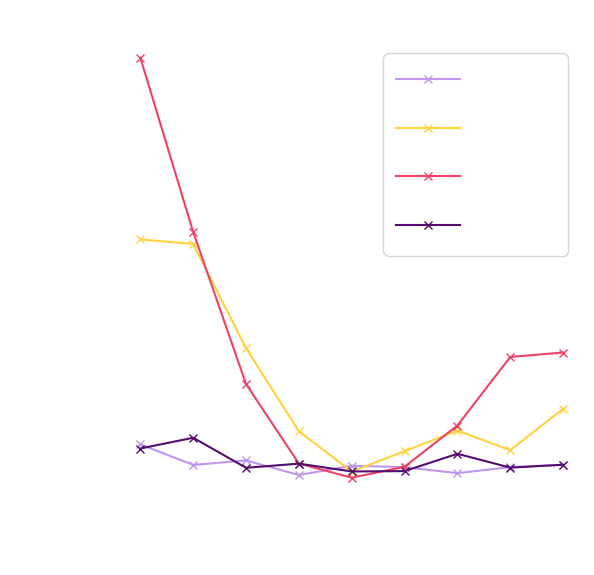

In [20]:
plt.rcParams["figure.figsize"] = (6, 6)
# T_permuted = apply_inv_permutations([df_base_na100[f'dim_{i}'] for i in range(1,5)])
id = list(range(4))
iperm = apply_inv_permutations(id)
for i,ip in zip(id,iperm):
    plt.plot(gain_list, df_base_na100[f'dim_{i+1}'], marker='x', color=colors_pit[i],label=labels_pit[i])

plt.xlabel(r'$g_0$', fontsize=15)
plt.ylabel(r'$T_{i}(x_0)$', fontsize=15)
plt.title(r'Test statistics', fontsize=18)
plt.legend()
plt.show()

### Null hypothesis

In [21]:
ntrials=100
path_lct_base_t100_na100 = (
    path_lct + f"baseline/lct_results_baseline_mlp_nalpha_100_ntrials_{ntrials}_n_alphas_{100}"
) 

gain_list_new = [-20,0,20]

r_alpha_null_list = []
for g in gain_list_new:
    dict_null = torch.load(path_lct_base_t100_na100 + f"_gain_{g}.pkl")
    r_alpha_null = {}
    for k in range(ntrials):
        r_alpha_null[k] = pd.Series(dict_null['r_alpha_null_list'][k]['dim_1'])
    r_alpha_null_list.append(r_alpha_null)

### p-values

In [22]:
df = get_lct_results(lct_base_t1000_na100_path_list)
df.loc[:, df.columns.str.contains('p_values')]

,p_values__dim_1,p_values__dim_2,p_values__dim_3,p_values__dim_4,p_values__hmean
0,0.00,0.0,0.00,0.01,0.0
1,0.00,0.0,0.00,0.00,0.0
2,0.00,0.0,0.00,0.00,0.0
3,0.03,0.0,0.00,0.00,0.0
4,0.00,0.0,0.12,0.00,0.0
5,0.00,0.0,0.00,0.00,0.0
6,0.10,0.0,0.00,0.00,0.0
7,0.00,0.0,0.00,0.02,0.0
8,0.15,0.0,0.00,0.12,0.0


/tmp/ipykernel_3100299/4082816926.py:4: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig(PATH_EXPERIMENT+'images_neurips/local_consistency.pdf')
/tmp/ipykernel_3100299/4082816926.py:4: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig(PATH_EXPERIMENT+'images_neurips/local_consistency.pdf')
/data/parietal/store/work/jlinhart/miniconda3/envs/sdbm/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


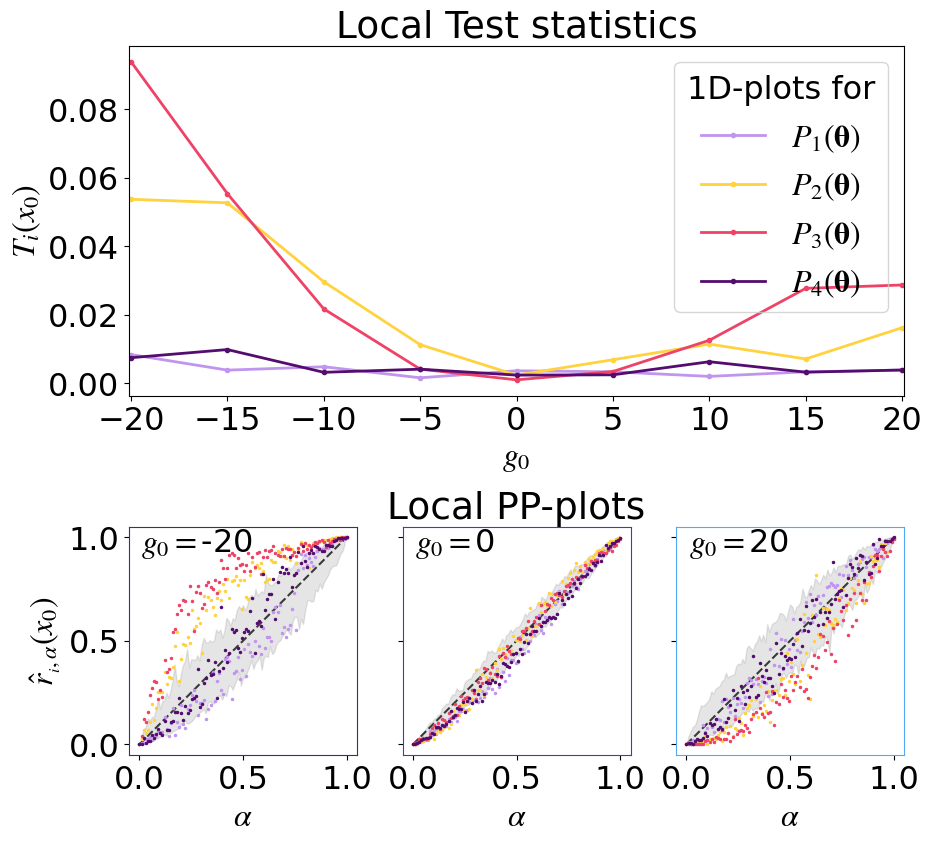

In [23]:
from plots_neurips2022 import multi_local_consistency
colors = []
fig = multi_local_consistency(lct_base_t1000_na100_path_list, gain_list, colors_pit, labels_pit, r_alpha_null_list=r_alpha_null_list, conf_alpha=0.05/4) # bonferonni correction
plt.savefig(PATH_EXPERIMENT+'images_neurips/local_consistency.pdf')

### PP-plots

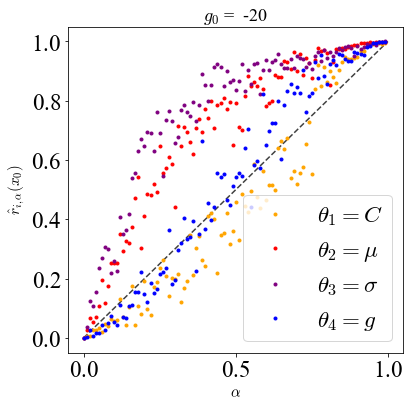

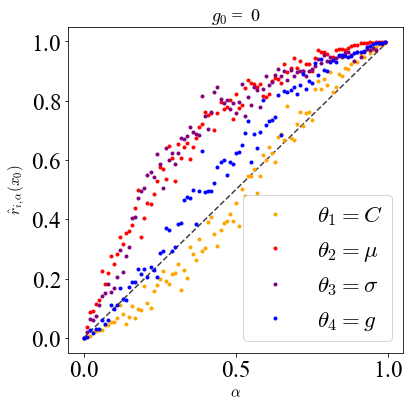

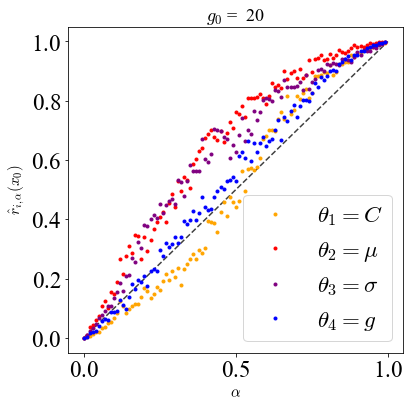

In [21]:
# pp-plots for accepted x_0
from diagnostics.pp_plots import multi_pp_plots
plt.rcParams["figure.figsize"] = (6, 6)
x_eval_names = [r"$g_0$ = " + f" {g}" for g in gain_list]
param_names = [r"$\theta_1=C$ ", r"$\theta_2=\mu$ ", r"$\theta_3=\sigma$ ", r"$\theta_4=g$ "]
multi_pp_plots(
    [
        # [
        #     lct_base_t1000_na100_path_list[0],
        #     lct_base_t1000_na100_path_list[4],
        #     lct_base_t1000_na100_path_list[8],
        # ]
        lct_base_t1000_na100_path_list
    ],
    x_eval_names,
    param_names,
    pvalues=False,
    title="",
    ylabel=r"$\hat{r}_{i,\alpha}(x_0)$"
)



### Mutual Independance: Estimate the local correlation coefficients

In [58]:
eig_1 = np.linalg.eig(df_flow_transform.corr())[1][0]
np.matmul(np.matmul(eig_1, targets), eig_1.reshape(-1,1)).ravel().shape

(10000, 1)

In [59]:
from sklearn.neural_network import MLPRegressor
clf = MLPRegressor(alpha=0, max_iter=25000)
targets = np.array([np.matmul(np.array(df_flow_transform.loc[i]).reshape(-1,1), np.array(df_flow_transform.loc[i]).reshape(1,4)) for i in range(B_PRIME)])
targets = np.matmul(np.matmul(eig_1, targets), eig_1.reshape(-1,1))
clf.fit(X = x_test[:,:,0], y = targets.ravel())


/data/parietal/store/work/jlinhart/miniconda3/envs/sdbm/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLPRegressor(alpha=0, max_iter=25000)

In [47]:
clf.predict(x_obs_list[1][None,:,0])

(10000, 4, 4)

In [ ]:
from sklearn.neural_network import MLPRegressor
import matplotlib.cbook as cbook

for ind, gain in zip([1,5,9], [-20,0,20]):
    clfs, results = local_correlation_regression(df_flow_transform, x_test[:,:,0], x_eval=x_obs_list[ind][None,:,0])

    results_null = []
    for k in range(n_trials):
        clfs, result_null = local_correlation_regression(null_df_list[k], x_test[:,:,0], x_eval=x_obs_list[ind][None,:,0])
        results_null.append(result_null['12'])
    
    data = results_null
    stats = cbook.boxplot_stats(data)[0]
    stats['q1'] = np.quantile(data, 0.05)
    stats['q3'] = np.quantile(data, 0.95)
    stats['whislo'] = min(data)
    stats['whishi'] = max(data)
    labels = ['12', '13', '14', '23', '24', '34']

    fig, ax = plt.subplots(1, 1)
    bp = ax.bxp([stats],widths=0.1, vert=False, showfliers=False,)
    for label in labels:
        if (stats['q1'] <= results[label] <= stats['q3']):
            color = 'green'
        elif (stats['whislo'] <= results[label] <= stats['whishi']):
            color='orange'
        else:
            color = 'red'
        plt.text(results[label], 1.02, label, color=color)
        plt.scatter(results[label], 1, color=color)

    # plt.legend()
    plt.title('95% interval for normal distributions')
    plt.suptitle(r'Correlation coefficient, $g_0=$'+str(gain))
    plt.show()

/data/parietal/store/work/jlinhart/miniconda3/envs/sdbm/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


## Choice of regression model


### 1. Recovery of the true Expected PIT 

We will compare the baseline method and these selected HG-regressors in terms of recovery of the true PIT values of our flow on an evaluation dataset of the joint $\{(\Theta_i, X_i), i=1,\dots, n_{eval}\}$.

The estimated local PIT values are:
$$\hat{r}_{\alpha}(X) \approx \mathbb{P}_{\Theta \mid X}(\text{PIT}(\Theta, X ; q_{\phi}) \leq \alpha) = \mathbb{E}[\mathbb{1}_{\{\text{PIT}(\Theta, X ; q_{\phi}) \leq \alpha\}}\mid X]$$

We can compute the expected estimated PIT values over the evaluation dataset and compare them to the real expected PIT values:

$$\hat{E}(\alpha) = \frac{1}{n_{eval}} \sum_{i=1}^{n_{eval}} \hat{r}_{\alpha}(X_i) \quad \text{vs.} \quad E(\alpha) = \frac{1}{n_{eval}}\sum_{i=1}^{n_{eval}} \mathbb{1}_{\{\text{PIT}(\Theta_i, X_i ; q_{\phi}) \leq \alpha\}}$$

We do this by computing the MSE over a grid of alpha values `np.linspace(0,0.99,m)` (with `m=100`):

$$ \frac{1}{m}\sum_{t=1}^{m} (\hat{E}(\alpha_t) - E(\alpha_t))^2$$

We compute the mean and std over 10 models per regression method.

In [10]:
# TRUE EXPECTED PIT-DISTRIBUTION of the trained estimators
theta_test, x_test = datasets['B_double_prime']['theta'], datasets['B_double_prime']['x']

# Compute PIT-values of the flows 
# [PIT(Theta_i, X_i, maf_good) = F_{Q_good|X_i}(Theta_i)
flow_joint_pit_values = multi_cde_pit_values(
    theta_test, x_test, posterior, feature_transform=identity
)

In [10]:
from diagnostics.pp_plots import PP_vals

nb_classifiers = 10
method_names = ['baseline', 'hg10','hg20','hg30', 'hg40', 'hg50', 'hg60', 'hg70', 'hg80', 'hg90', 'hg100', 'hg110', 'hg120']

euc_dist_list = {}
for method_name in method_names:
    euc_dist_list[method_name] = {}
    # Load Estimated Expected PIT values 
    E_hat_loaded = torch.load(f'saved_experiments/JR-NMM/reg_eval/expected_pit_list_{method_name}.pkl')

    alphas = np.linspace(0,0.99,100)

    for i in range(1,5):
        # True Expected PIT values 
        E = PP_vals(flow_joint_pit_values[i-1], alphas)
        euc_dist_list[method_name][f'dim_{i}'] = {}
        euc_dist_list_c =[]
        for c in range(nb_classifiers):
            euc_dist_list_c.append(np.mean((E_hat_loaded[c][f'dim_{i}'] - E)**2))

        euc_dist_list[method_name][f'dim_{i}']['mean'] = np.mean(euc_dist_list_c)
        euc_dist_list[method_name][f'dim_{i}']['std'] = np.std(euc_dist_list_c)
        euc_dist_list[method_name][f'dim_{i}'] = pd.Series(euc_dist_list[method_name][f'dim_{i}'])

In [14]:
import matplotlib as mpl
mpl.rcParams["font.family"] = "serif"
mpl.rcParams['axes.formatter.use_mathtext'] = True
mpl.rcParams['mathtext.fontset'] = 'cm'
method_names = ['baseline', 'hg10','hg20','hg30', 'hg40', 'hg50', 'hg60', 'hg70', 'hg80', 'hg90', 'hg100', 'hg110', 'hg120']

max_iter_list = np.linspace(10,120,12,dtype=int)

# xticks =[]
# for it in range(1,10):
#     xticks+=['',str(it*20)]

means = np.array([np.mean([euc_dist_list[method_name][f'dim_{i}']['mean'] for i in range(1,5)]) for method_name in method_names[1:]])
stds = np.array([np.mean([euc_dist_list[method_name][f'dim_{i}']['std'] for i in range(1,5)]) for method_name in method_names[1:]])
plt.plot(max_iter_list, means, marker='x')
plt.fill_between(max_iter_list, means-stds, means+stds, alpha=0.1)

mean_base = np.mean([euc_dist_list['baseline'][f'dim_{i}']['mean'] for i in range(1,5)])
std_base = np.mean([euc_dist_list['baseline'][f'dim_{i}']['std'] for i in range(1,5)])
plt.plot(max_iter_list, [mean_base]*len(max_iter_list), color='black', label='baseline mean')
plt.plot(max_iter_list, [mean_base+std_base]*len(max_iter_list), '--', color='black', label='baseline +std')
plt.plot(max_iter_list, [mean_base-std_base]*len(max_iter_list), '--', color='black', label='baseline -std')
plt.legend()
# plt.xticks(max_iter_list, xticks)
plt.xlabel('max_iter', fontsize=15)
plt.ylabel(r'$MSE(\hat{E}, E)$', fontsize=15)
plt.suptitle('MSE between estimated and true expected PIT', fontsize=18)
plt.title('Mean and STD over 10 models per method',fontsize=10)
plt.show()

NameError: name 'euc_dist_list' is not defined

All HG-methods are better than the baseline (lower MSE and less variance). Low variance is important for p-value computation.

### 2. Comparison of Test Statistics under the null hypothesis

The goal is to find the best regressor $\hat{r}_{\alpha}(X)$ to estimate the local PIT values defined for $\alpha \in [0,1]$ by the c.d.f of the PIT at $X$:
$$ r_{\alpha}(X) = \mathbb{P}_{\Theta \mid X}(\text{PIT}(\Theta, X ; q_{\phi}) \leq \alpha) = \mathbb{E}[\mathbb{1}_{\{\text{PIT}(\Theta, X ; q_{\phi}) \leq \alpha\}}\mid X]$$

Under null hypothesis of local consistency at $x_0$, the PIT at $X=x_0$ follows a uniform distribution, i.e. we have 
$$H_0 : \big(q_{\phi}(\Theta \mid x_0) = p(\Theta \mid x_0) \big) \quad  \Rightarrow \quad  r_{\alpha}(x_0) = \alpha, \quad \forall \alpha \in [0,1].$$ 

The deviance from the null hypothesis is quantified by the test statistic: 
$$T_m(x_0) = \frac{1}{m}\sum_{t=1}^m (r_{\alpha_t}(x_0)-\alpha_t)^2.$$

A good regressor should be able to correctly represent the null hypothesis: it should predict the identity function for a locally consistent estimator (the test statistic should be 0):
$$q_{\phi}(\Theta \mid x_0) = p(\Theta \mid x_0)  \quad  \Rightarrow \quad  \hat{r}_{\alpha}(x_0) = \alpha, \forall \alpha \in [0,1] \quad  \Rightarrow \quad  \hat{T}_m(x_0) = 0$$


Theoretically for uniform PIT-values $U$, $\mathbb{P}(U \leq \alpha \mid X) = \alpha$. So for a $X=x_0$, we should get test statistics close to zero (not equal because we are in a finite sample regime). 

In practice, we can therefore compare regression methods by comparing test statistics obtained under the null hypothesis, i.e. for uniformly distributed PIT-values, on average over several trials:

For every trial: 
- generate $U_i \sim \mathcal{U}(0,1)$ 
- regress $U_i$ on $X_i$ to learn $\hat{r}_{\alpha}(X)$ under $H_0$
- compute the test statistic for $X=x_0$ 

We compute the average test statistic over all trials (100).

We plot the mean nd std over different $x_0$ s.t. $g_0 \in [-15,15]$ to avoid border effects. 


In [238]:
# load the baseline regressors trained on uniform PIT values (100 trials and 21 alpha values)
path_lct = PATH_EXPERIMENT+f'lct_results/naive_nextra_{N_EXTRA}_nsim_{B}/gain/'
path_lct_baseline = path_lct+f'baseline/lct_results_baseline_mlp_nalpha_21_ntrials_100_n_alphas_21'

# load the histgradboost regressors trained on uniform PIT values (100 trials) and evaluated on 21 alpha values
path_lct_max_iter = PATH_EXPERIMENT + f"lct_results/naive_nextra_{N_EXTRA}_nsim_{B}/gain/max_iter_exp/lct_results_sample50_histgrad90_"

gain_list = np.linspace(-15,15,7,dtype=int)
# gain_list = [0]
max_iter_list = np.linspace(10,200,20,dtype=int)

T_null_base = []
test_stats_dict = {}
for g in gain_list:
    path_lct_baseline_g0 = path_lct_baseline+f'_gain_{g}.pkl'

    r_alpha_null_list_base_g0 = torch.load(path_lct_baseline_g0)['r_alpha_null_list']
    n_trials = len(r_alpha_null_list_base_g0)
    T_base_t100_na21_mean = 0
    for i in range(1,5):
        T_base_t100_na21 = []
        for t in range(n_trials):
            T_base_t100_na21.append(compute_test_statistic(r_alpha_null_list_base_g0[t][f'dim_{i}']))
        T_base_t100_na21_mean += np.mean(T_base_t100_na21)
    T_base_t100_na21_mean /=4
    T_null_base.append(T_base_t100_na21_mean)

    test_stats_dict[g] = {}
    for i in range(1,5):
        test_stats_dict[g][f'dim_{i}'] = {}
        test_stats_mean ={}
        test_stats_std = {}
        for it in max_iter_list:
            lct_max_iter_path_g = path_lct_max_iter + f"maxiter_{it}_ntrials_100_n_alphas_21_gain_{g}.pkl"

            r_alpha_null_list_g = torch.load(lct_max_iter_path_g)['r_alpha_null_list']
            n_trials = len(r_alpha_null_list_g)
            T_values = []
            for t in range(n_trials):
                T_values.append(compute_test_statistic(r_alpha_null_list_g[t][f'dim_{i}']))
            test_stats_mean[it] = np.mean(T_values)
            test_stats_std[it] = np.std(T_values)
        test_stats_dict[g][f'dim_{i}']['mean'] = pd.Series(test_stats_mean)
        test_stats_dict[g][f'dim_{i}']['std'] = pd.Series(test_stats_std)

T_dim ={}  
for i in range(1,5):
    T_dim[f'dim_{i}'] = {}
    T_dim[f'dim_{i}']['mean'] = {}
    T_dim[f'dim_{i}']['std'] = {}
    for it in max_iter_list:
        T_i_it = []
        for g in gain_list:
            T_i_it.append(test_stats_dict[g][f'dim_{i}']['mean'][it])
        T_dim[f'dim_{i}']['mean'][it] = np.mean(T_i_it)
        T_dim[f'dim_{i}']['std'][it] = np.std(T_i_it)
    T_dim[f'dim_{i}']['mean'] = pd.Series(T_dim[f'dim_{i}']['mean'])
    T_dim[f'dim_{i}']['std'] = pd.Series(T_dim[f'dim_{i}']['std'])

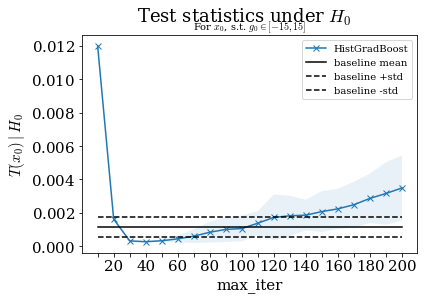

In [240]:
import matplotlib as mpl
mpl.rcParams["font.family"] = "serif"
mpl.rcParams['axes.formatter.use_mathtext'] = True
mpl.rcParams['mathtext.fontset'] = 'cm'

max_iter_list = np.linspace(10,200,20,dtype=int)

xticks =[]
for it in range(1,11):
    xticks+=['',str(it*20)]

i = 1 # same for every dim so we choose one 
T_dim[f'dim_{i}']['mean'].plot(marker='x', label='HistGradBoost')
error = T_dim[f'dim_{i}']['std']
y = T_dim[f'dim_{i}']['mean']
plt.fill_between(max_iter_list, y-error, y+error, alpha=0.1)

plt.plot(max_iter_list, [np.mean(T_null_base)]*len(max_iter_list), color='black', label='baseline mean')
plt.plot(max_iter_list, [np.mean(T_null_base)+np.std(T_null_base)]*len(max_iter_list), '--', color='black', label='baseline +std')
plt.plot(max_iter_list, [np.mean(T_null_base)-np.std(T_null_base)]*len(max_iter_list), '--', color='black', label='baseline -std')
plt.legend()
plt.xticks(np.linspace(10,200,20), xticks)
plt.xlabel('max_iter', fontsize=15)
plt.ylabel(r'$T(x_0) \mid H_0$', fontsize=15)
plt.suptitle(r'Test statistics under $H_0$', fontsize=18)
plt.title(r'For $x_0$, s.t. $g_0 \in [-15,15]$', fontsize=10)
plt.show()

Valid `max_iter` values for our `HistGradBoostClassifier` with default parameters go from 30 to 90/100. They give lower test statistics under the null than the baseline while keeping a low variance over the trials.

We will check which one is better at estimating PIT values for complex data distributions that are not calibrated.  Intuitively this will be the one with the highest number of iterations (i.e. max_iter = 90/100). 

We do this by looking at the evolution of the LCT test statistic over the gain parameter space. It should be 
- in a well defined U-shape 
- as small as possible in $g_0 = 0$, where we expect the test to pass

In [11]:
path_lct = PATH_EXPERIMENT + f"lct_results/naive_nextra_{N_EXTRA}_nsim_{B}/gain/"

path_lct_base_t1000_na100 = (
    path_lct + f"baseline/lct_results_baseline_mlp_nalpha_100_ntrials_{1000}_n_alphas_{100}"
)  # no pvalues, used to plot pp-pplot

path_lct_hg30_t1000_na100 = (
    path_lct + f"histgrad30/lct_results_sample50_histgrad90_maxiter_30_ntrials_{1000}_n_alphas_{100}"
)  # more trials for pvalues nd more alpha values, not available for baseline

path_lct_hg90_t1000_na100 = (
    path_lct + f"histgrad90/lct_results_sample50_histgrad90_ntrials_{1000}_n_alphas_{100}"
)  # more trials for pvalues nd more alpha values, not available for baseline

path_lct_hg100_t1000_na100 = (
    path_lct + f"histgrad100/lct_results_sample50_histgrad90_maxiter_100_ntrials_{1000}_n_alphas_{100}"
)  # more trials for pvalues nd more alpha values, not available for baseline


gain_list = np.linspace(-20, 20, 9, dtype=int)

lct_base_t1000_na100_path_list = []
lct_hg30_t1000_na100_path_list = []
lct_hg90_t1000_na100_path_list = []
lct_hg100_t1000_na100_path_list = []


for g in gain_list:
    lct_base_t1000_na100_path_list.append(path_lct_base_t1000_na100 + f"_gain_{g}.pkl")
    lct_hg30_t1000_na100_path_list.append(path_lct_hg30_t1000_na100 + f"_gain_{g}.pkl")
    lct_hg90_t1000_na100_path_list.append(path_lct_hg90_t1000_na100 + f"_gain_{g}.pkl")
    lct_hg100_t1000_na100_path_list.append(path_lct_hg100_t1000_na100 + f"_gain_{g}.pkl")


    

from diagnostics.multi_local_test import get_lct_results

df_base_na100 = get_lct_results(lct_base_t1000_na100_path_list, pvalues=False)
df_base_na100.index = gain_list

df_hg90_t1000_na100 = get_lct_results(lct_hg90_t1000_na100_path_list, pvalues=False)
df_hg90_t1000_na100.index = gain_list

df_hg30_t1000_na100 = get_lct_results(lct_hg30_t1000_na100_path_list, pvalues=False)
df_hg30_t1000_na100.index = gain_list

df_hg100_t1000_na100 = get_lct_results(lct_hg100_t1000_na100_path_list, pvalues=False)
df_hg100_t1000_na100.index = gain_list

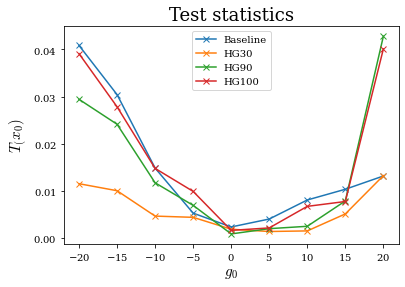

In [12]:
import matplotlib as mpl
mpl.rcParams["font.family"] = "serif"
mpl.rcParams['axes.formatter.use_mathtext'] = True
mpl.rcParams['mathtext.fontset'] = 'cm'

colors=["orange", "red", "purple", "blue"]
labels = [r'$\Theta_1 = C$', r'$\Theta_2 = \mu$', r'$\Theta_3 = \sigma$', r'$\Theta_4 = g$']

plt.plot(gain_list, np.mean([df_base_na100[f'dim_{i}'] for i in range(1,5)], axis=0), marker='x', label='Baseline')
plt.plot(gain_list, np.mean([df_hg30_t1000_na100[f'dim_{i}'] for i in range(1,5)], axis=0), marker='x', label='HG30')
plt.plot(gain_list, np.mean([df_hg90_t1000_na100[f'dim_{i}'] for i in range(1,5)], axis=0), marker='x', label='HG90')
plt.plot(gain_list, np.mean([df_hg100_t1000_na100[f'dim_{i}'] for i in range(1,5)], axis=0), marker='x', label='HG100')

# plt.plot(np.mean([df_hg100_t1000_na100[f'dim_{i}'] for i in range(1,5)], axis=0), marker='x', label='HG100')
plt.legend()
plt.xlabel(r'$g_0$', fontsize=15)
plt.ylabel(r'$T_(x_0)$', fontsize=15)
plt.title(r'Test statistics', fontsize=18)
plt.show()
plt.show()

The HG90 seems best. 

##### Plot p-values

In [250]:
path_lct = PATH_EXPERIMENT + f"lct_results/naive_nextra_{N_EXTRA}_nsim_{B}/gain/"

path_lct_base_t100_na21 = (
    path_lct + f"baseline/lct_results_baseline_mlp_nalpha_21_ntrials_{100}_n_alphas_{21}"
)  # with pvalues

path_lct_hg90_t100_na21 = (
    path_lct + f"histgrad90/lct_results_sample50_histgrad90_ntrials_{100}_n_alphas_{21}"
)  # with pvalues, used to compare to baseline
path_lct_hg90_t1000_na21 = (
    path_lct + f"histgrad90/lct_results_sample50_histgrad90_ntrials_{1000}_n_alphas_{21}"
)  # more trials for pvalues, not available for baseline

gain_list = np.linspace(-20, 20, 9, dtype=int)

lct_base_t100_na21_path_list = []

lct_hg90_t100_na21_path_list = []
lct_hg90_t1000_na21_path_list = []

for g in gain_list:
    lct_base_t100_na21_path_list.append(path_lct_base_t100_na21 + f"_gain_{g}.pkl")

    lct_hg90_t100_na21_path_list.append(path_lct_hg90_t100_na21 + f"_gain_{g}.pkl")
    lct_hg90_t1000_na21_path_list.append(path_lct_hg90_t1000_na21 + f"_gain_{g}.pkl")

In [253]:
df_base_t100_na21 = get_lct_results(lct_base_t100_na21_path_list)
df_base_t100_na21.columns = df_base_t100_na21.columns.str.split('__', expand=True)
df_base_t100_na21.index = gain_list

df_hg90_t100_na21 = get_lct_results(lct_hg90_t100_na21_path_list)
df_hg90_t100_na21.columns = df_hg90_t100_na21.columns.str.split('__', expand=True)
df_hg90_t100_na21.index = gain_list

df_hg90_t1000_na21 = get_lct_results(lct_hg90_t1000_na21_path_list)
df_hg90_t1000_na21.columns = df_hg90_t1000_na21.columns.str.split('__', expand=True)
df_hg90_t1000_na21.index = gain_list



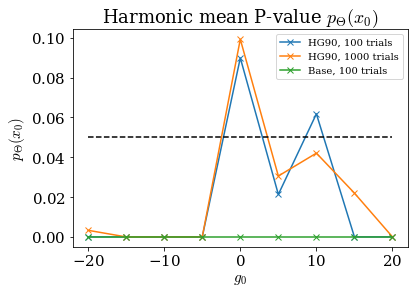

In [260]:
import matplotlib as mpl
mpl.rcParams["font.family"] = "serif"
mpl.rcParams['axes.formatter.use_mathtext'] = True
mpl.rcParams['mathtext.fontset'] = 'cm'

gain_list = np.linspace(-20,20,9)

# HISTGRAD 
plt.plot(gain_list, df_hg90_t100_na21['p_values']['hmean'], marker='x', label='HG90, 100 trials')
plt.plot(gain_list, df_hg90_t1000_na21['p_values']['hmean'], marker='x', label='HG90, 1000 trials')
plt.plot(gain_list, df_base_t100_na21['p_values'][f'hmean'], marker='x', label='Base, 100 trials')
plt.legend()
plt.plot(gain_list,np.ones_like(gain_list)*0.05, '--', color='black')
plt.xlabel(r'$g_0$', fontsize=15)
plt.ylabel(r'$p_{\Theta}(x_0)$', fontsize=15)
plt.title(r'Harmonic mean P-value $p_{\Theta}(x_0)$', fontsize=18)
plt.show()

##### Plot Multi-Test results (not hmean)

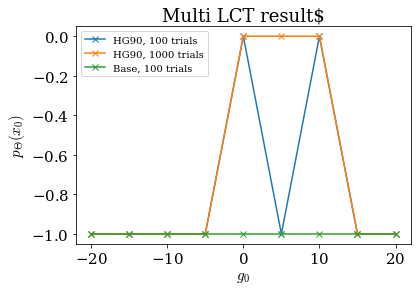

In [261]:
import matplotlib as mpl
mpl.rcParams["font.family"] = "serif"
mpl.rcParams['axes.formatter.use_mathtext'] = True
mpl.rcParams['mathtext.fontset'] = 'cm'

gain_list = np.linspace(-20,20,9)

# HISTGRAD 
plt.plot(gain_list, df_hg90_t100_na21['lct_results']['combined']*-1, marker='x', label='HG90, 100 trials')
plt.plot(gain_list, df_hg90_t1000_na21['lct_results']['combined']*-1, marker='x', label='HG90, 1000 trials')
plt.plot(gain_list, df_base_t100_na21['lct_results']['combined']*-1, marker='x', label='Base, 100 trials')
plt.legend()
plt.xlabel(r'$g_0$', fontsize=15)
plt.ylabel(r'$p_{\Theta}(x_0)$', fontsize=15)
plt.title(r'Multi LCT result$', fontsize=18)
plt.show()

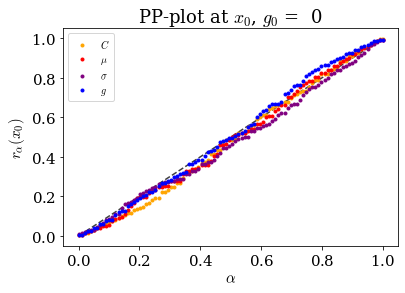

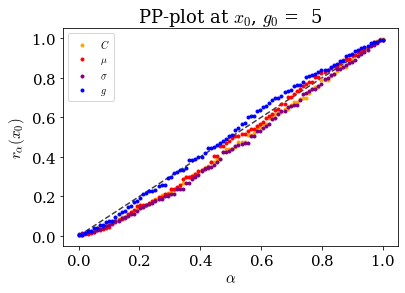

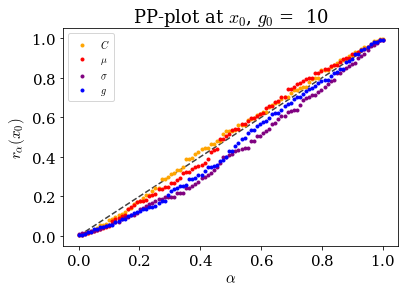

In [263]:
# pp-plots for accepted x_0
from diagnostics.pp_plots import multi_pp_plots
x_eval_names = [r', $g_0$ = '+f' {g}' for g in [0,5,10]]
param_names = [r'$C$ ', r'$\mu$ ', r'$\sigma$ ', r'$g$ ']
multi_pp_plots([lct_hg90_t1000_na100_path_list[4:7]] , x_eval_names, param_names,pvalues=False)

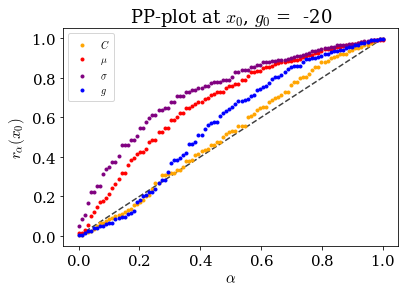

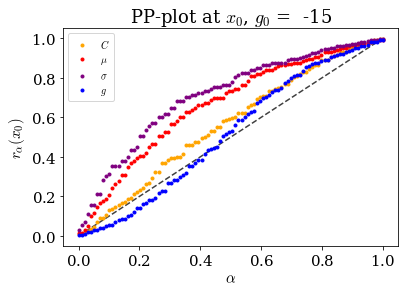

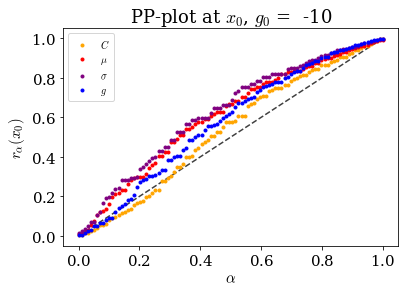

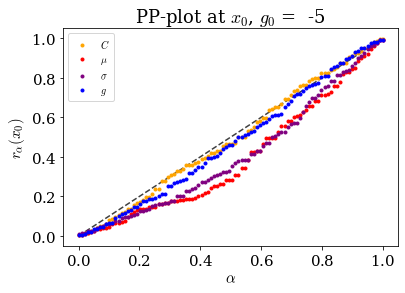

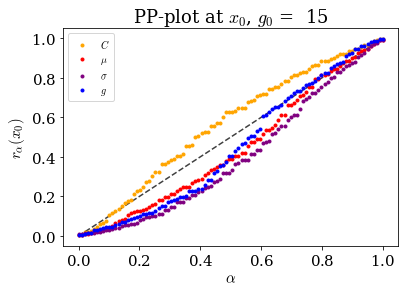

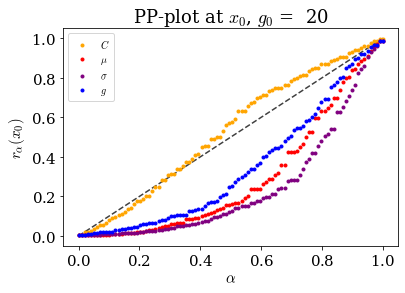

In [264]:
# pp-plots for rejected x_0
from diagnostics.pp_plots import multi_pp_plots
x_eval_names = [r', $g_0$ = '+f' {g}' for g in [-20,-15,-10,-5,15,20]]
param_names = [r'$C$ ', r'$\mu$ ', r'$\sigma$ ', r'$g$ ']
multi_pp_plots([lct_hg90_t1000_na100_path_list[:4]+lct_hg90_t1000_na100_path_list[7:]] , x_eval_names, param_names,pvalues=False)

#### Option two: PCA Image

##### Generate test observations $x_0$ 


In [24]:
# # ground-truth parameters to generate observation
# theta_obs, x_obs = simulate_for_sbi(
#         simulator=simulator, proposal=prior, num_simulations=20
# )
# x_obs = summary_extractor(x_obs)
# torch.save([theta_obs,x_obs], PATH_EXPERIMENT+'gt_observations/nextra_0/pca_experiment_new.pkl')
x_obs = torch.load(PATH_EXPERIMENT+'gt_observations/nextra_0/pca_experiment_new.pkl')[1]

# from sklearn.decomposition import PCA
# pca = PCA(n_components=2)
# pca.fit(x_obs[:,:,0]) 
# x_new = pca.transform(x_obs[:,:,0])
# plt.scatter(x_new[:,0],x_new[:,1], color='blue')

##### Compute and combine p-values

0


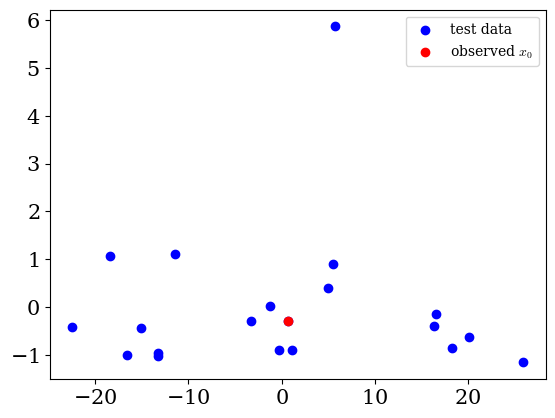

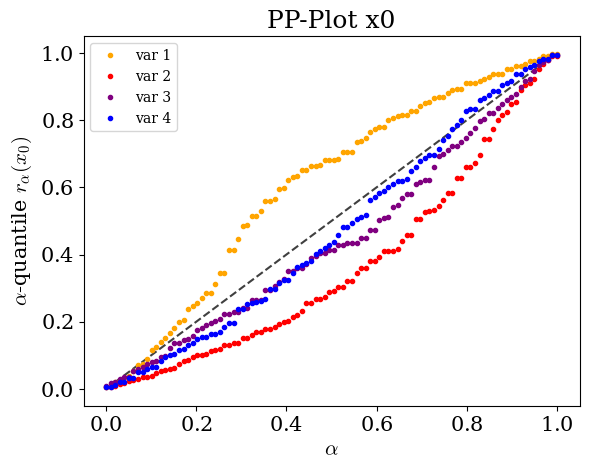

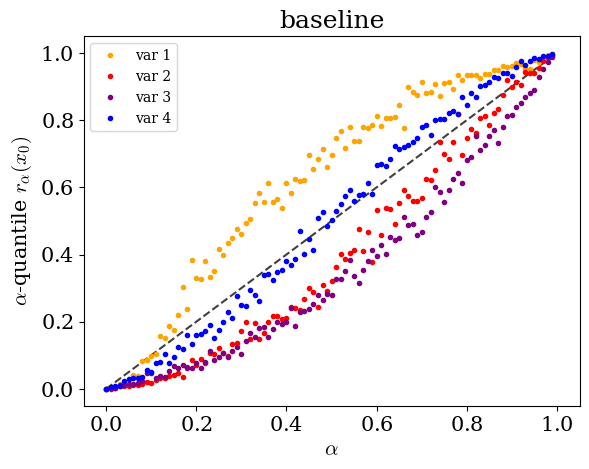

1


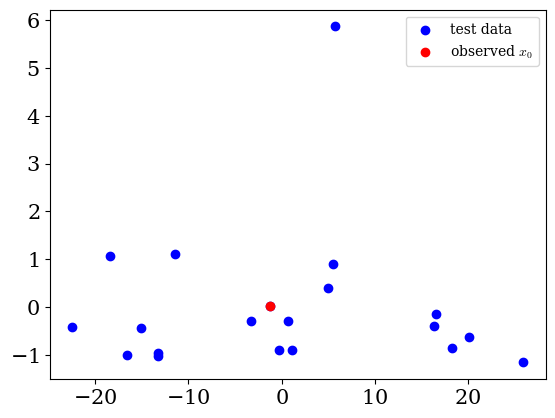

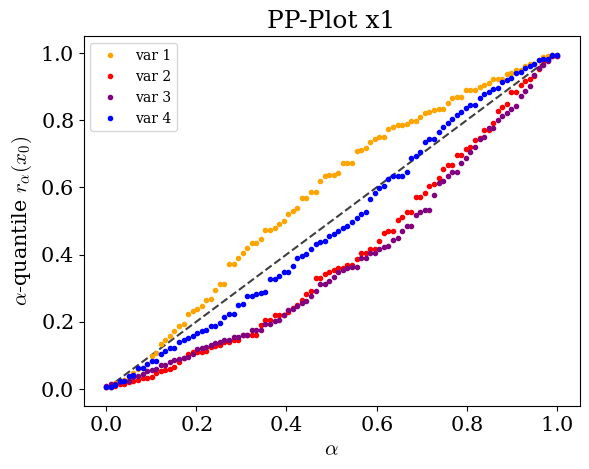

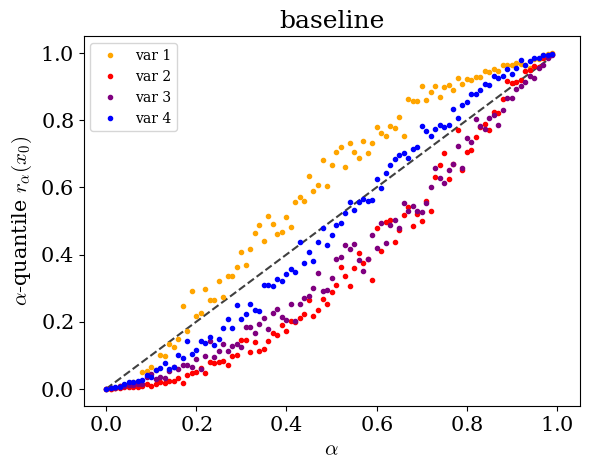

2


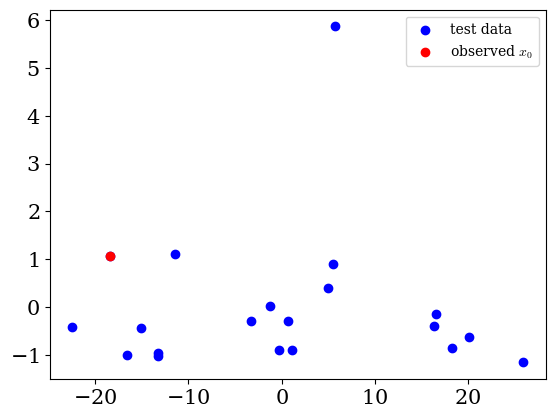

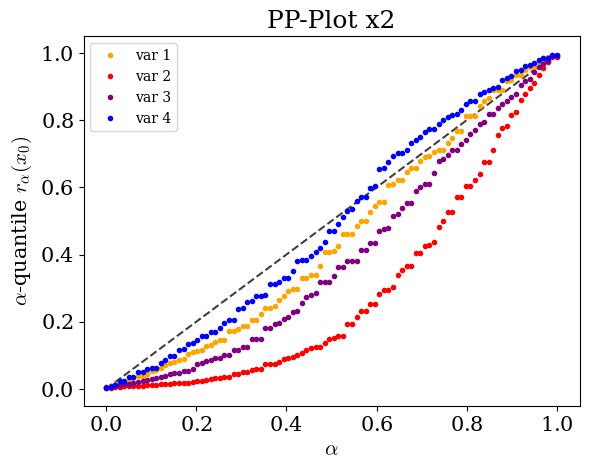

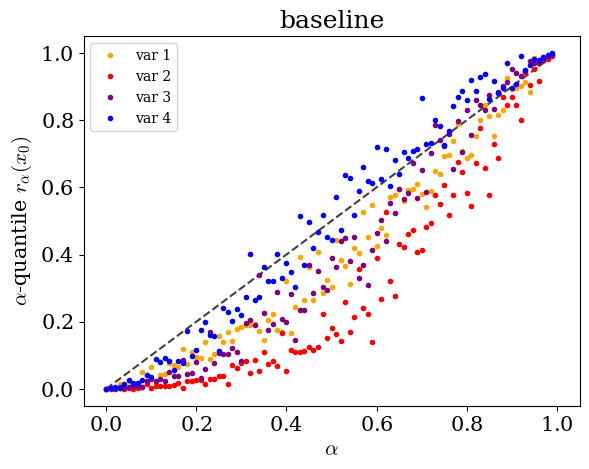

3


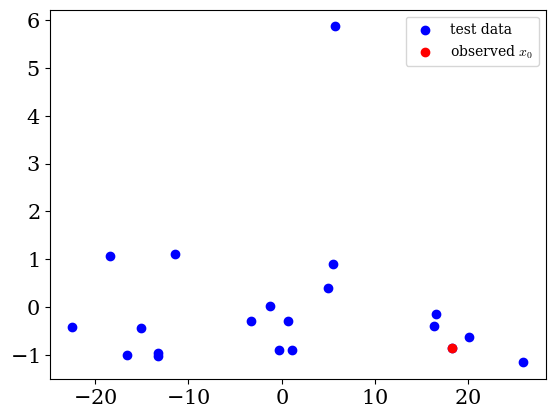

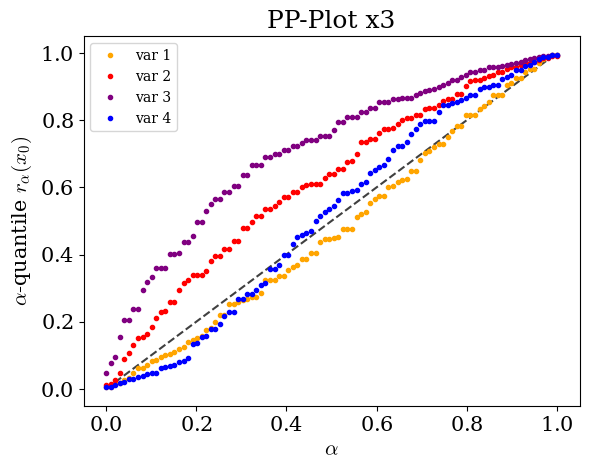

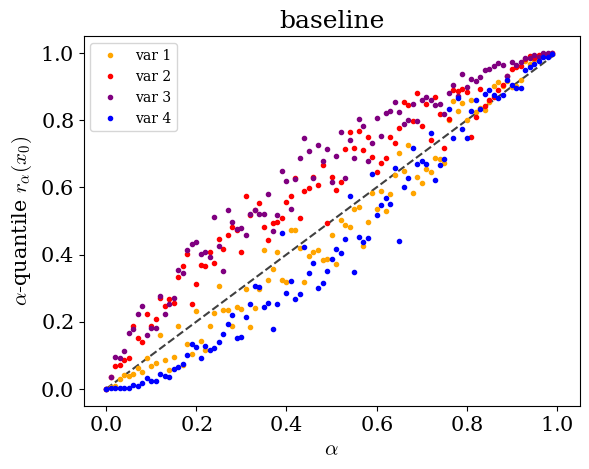

4


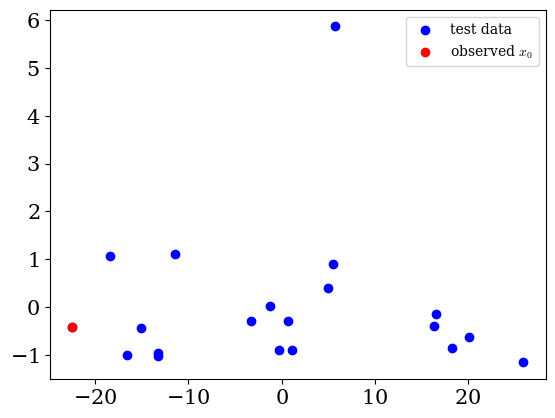

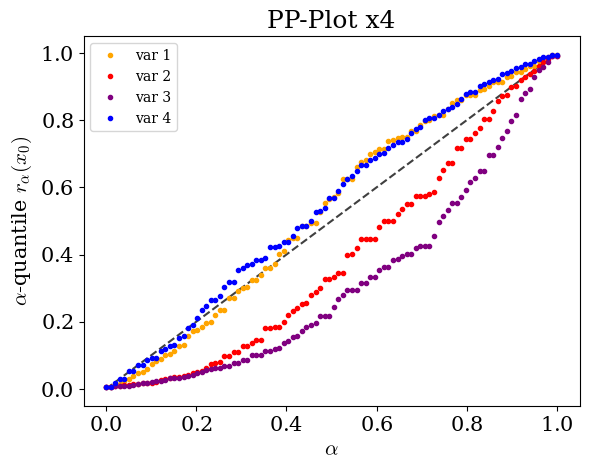

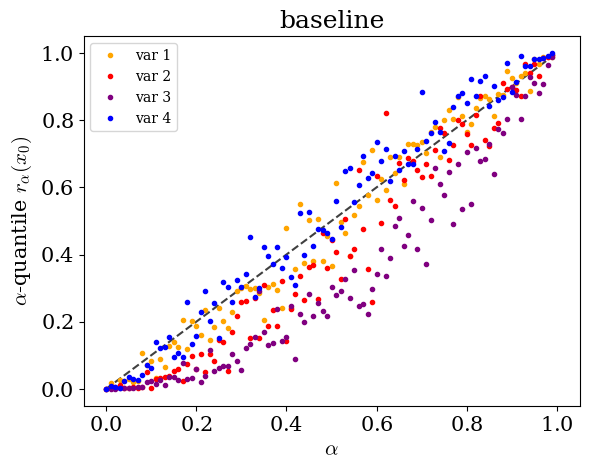

5


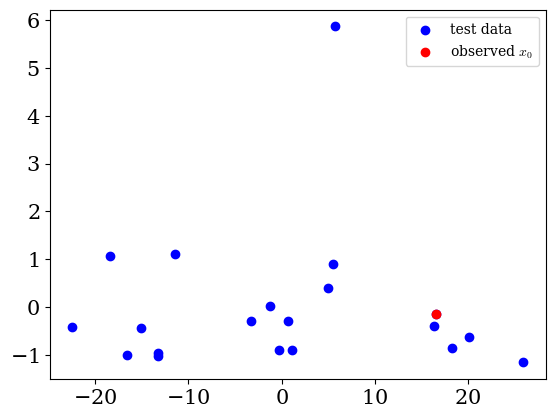

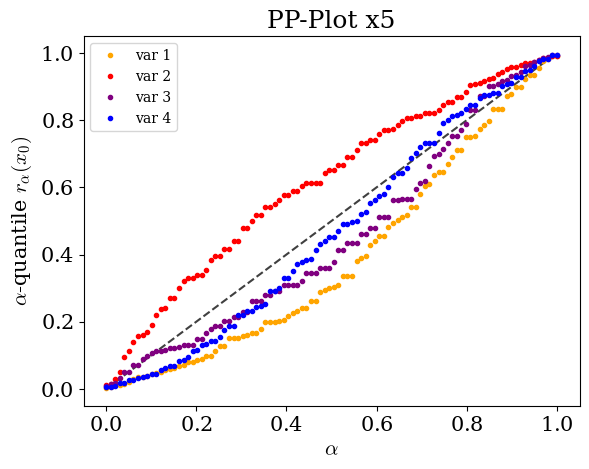

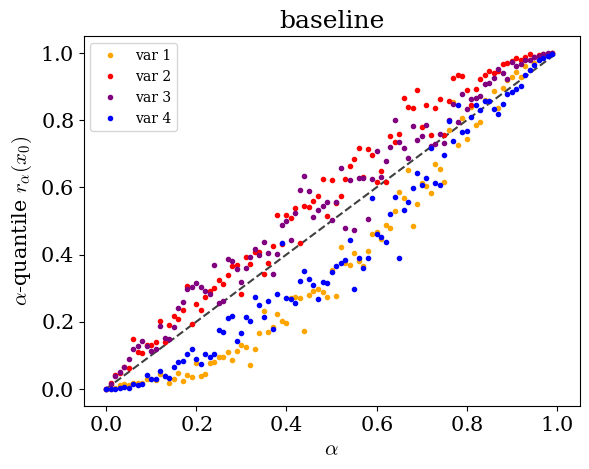

6


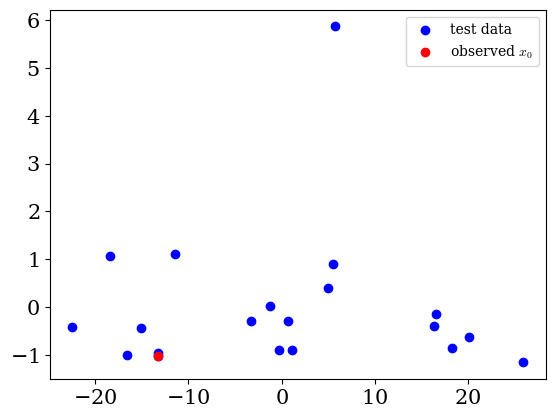

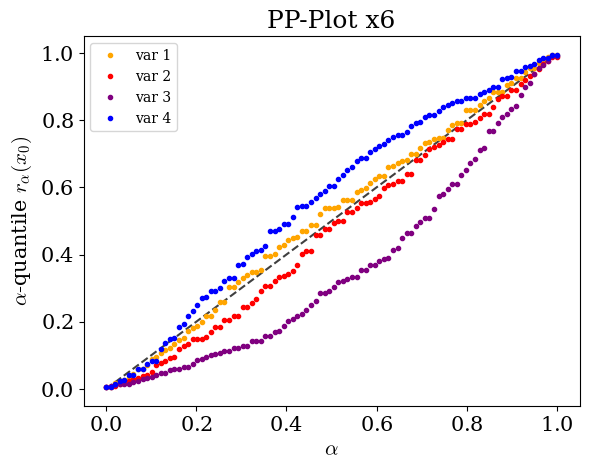

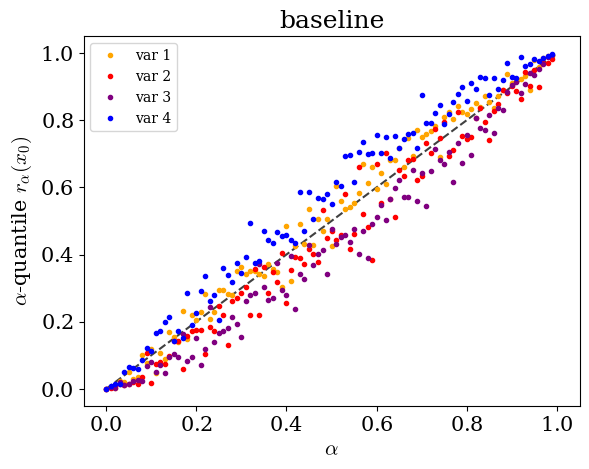

7


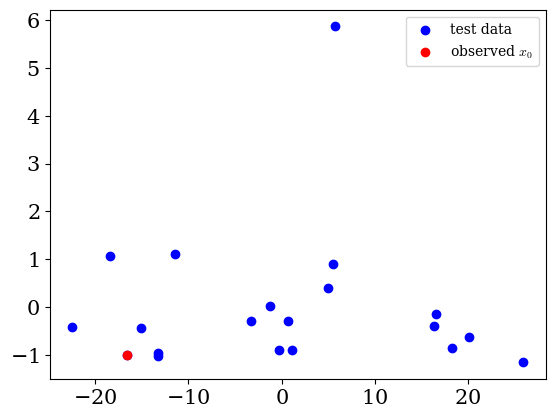

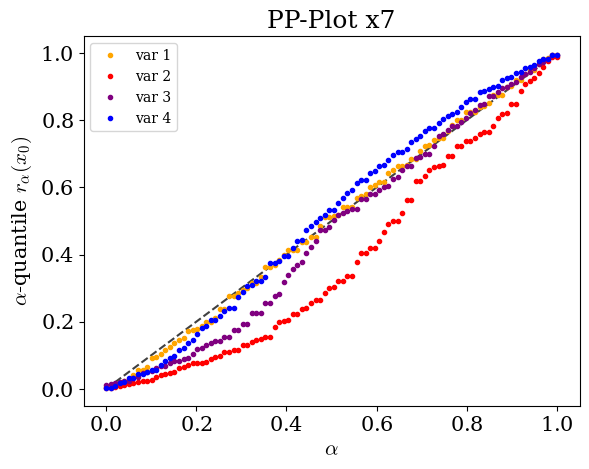

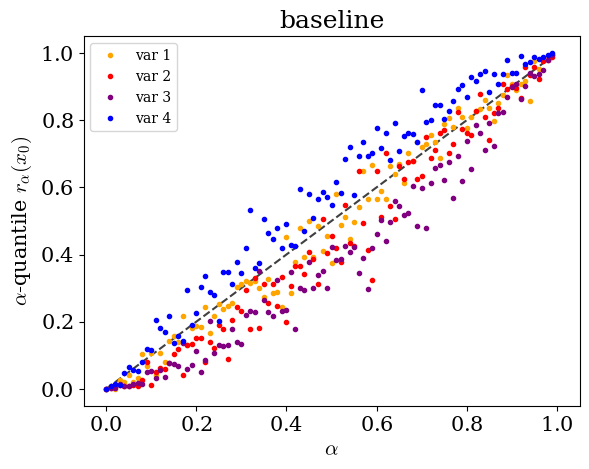

8


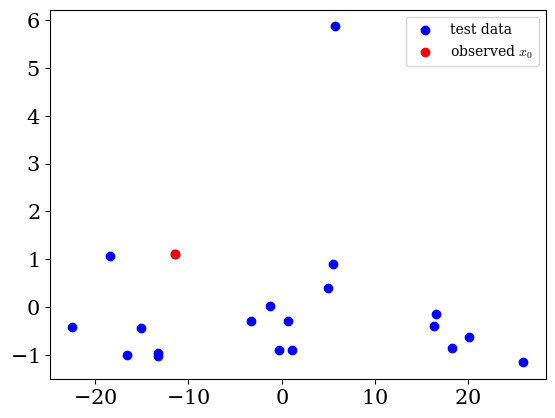

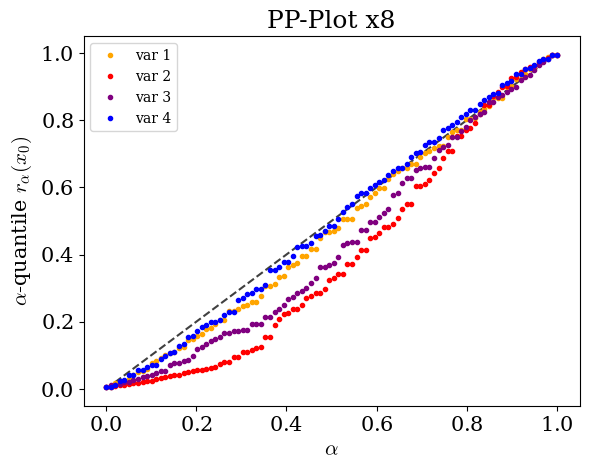

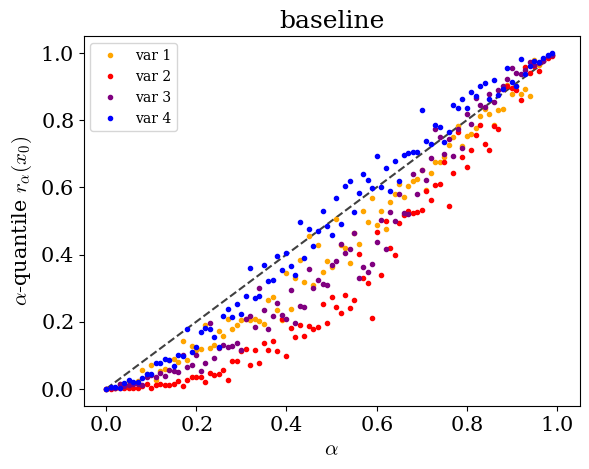

9


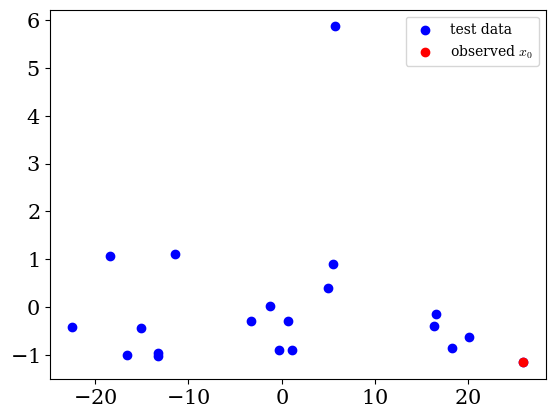

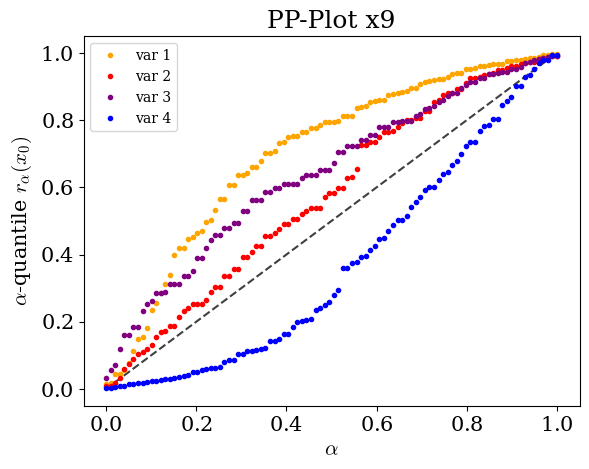

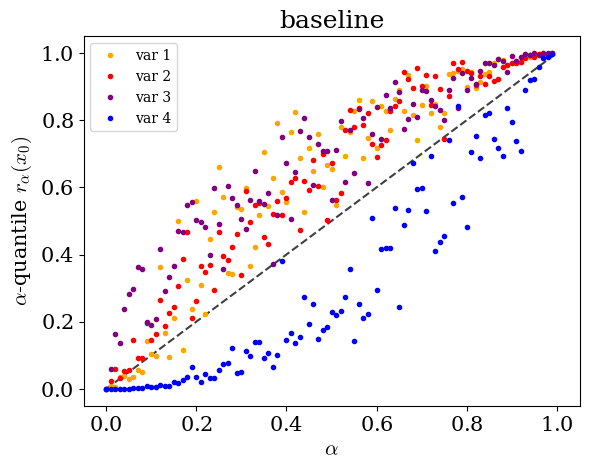

10


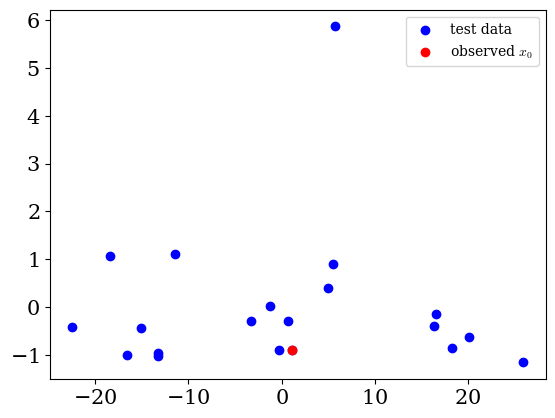

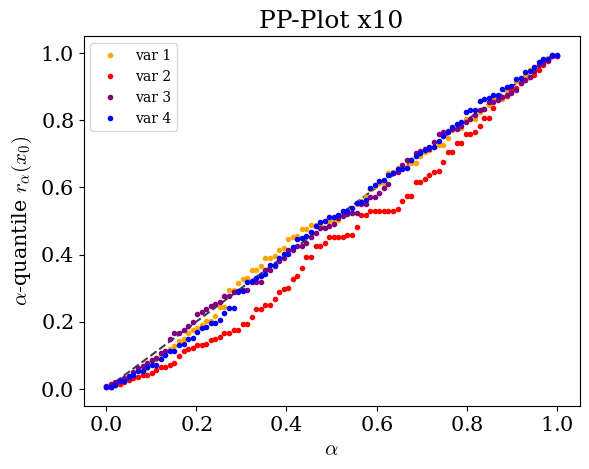

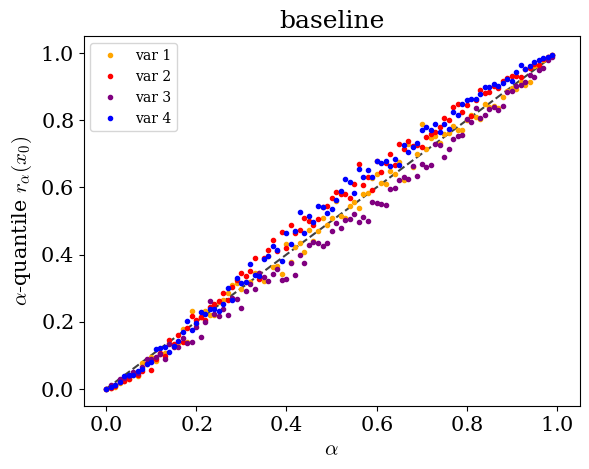

11


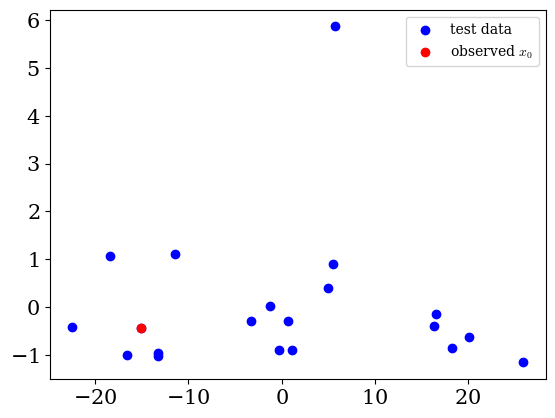

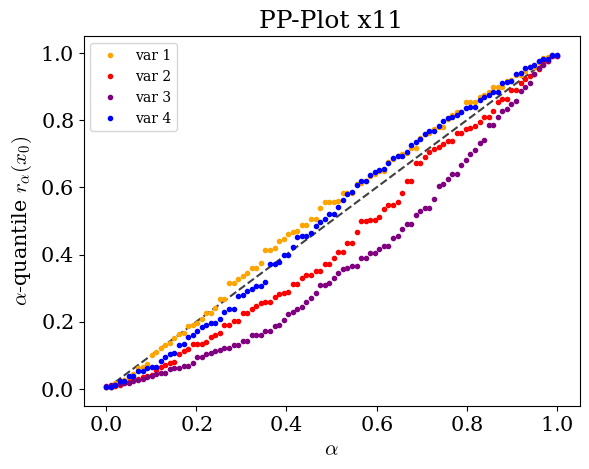

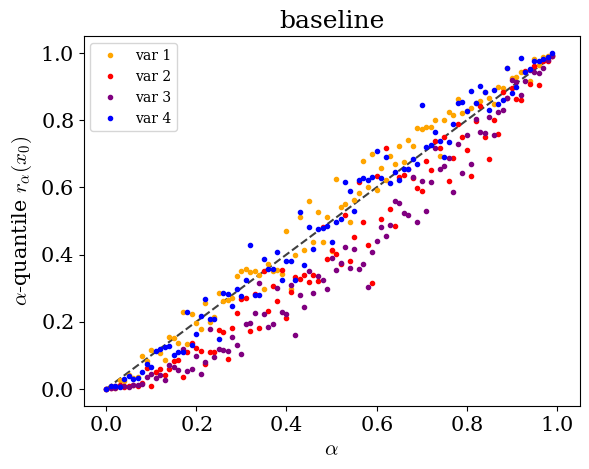

12


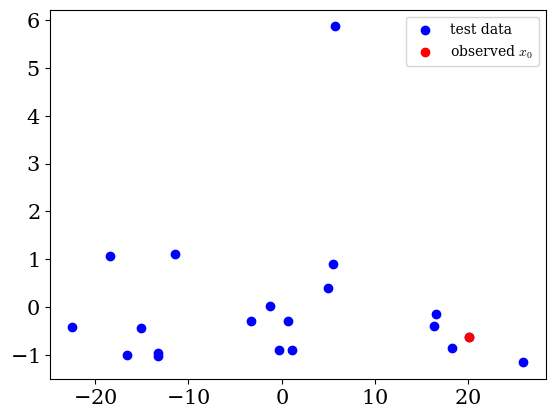

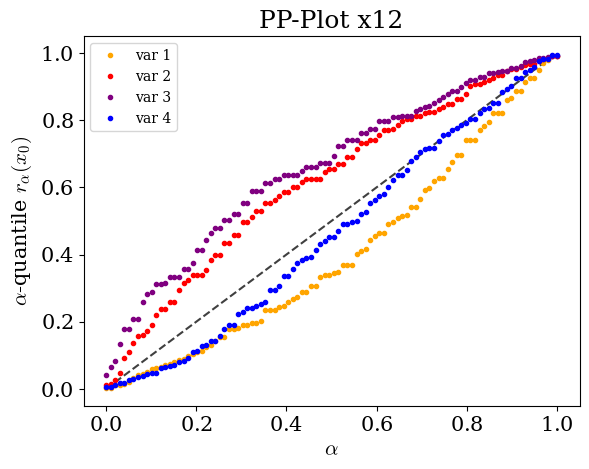

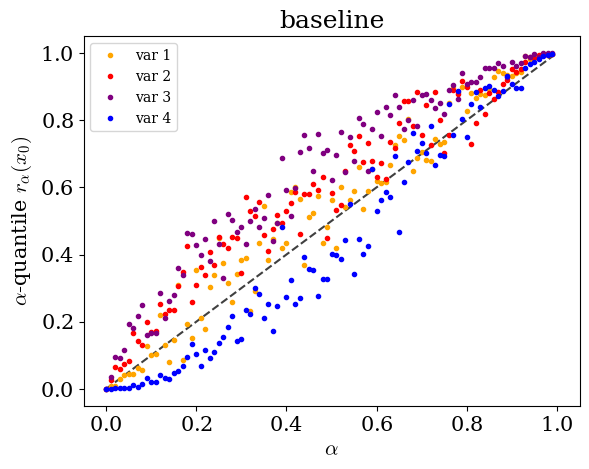

13


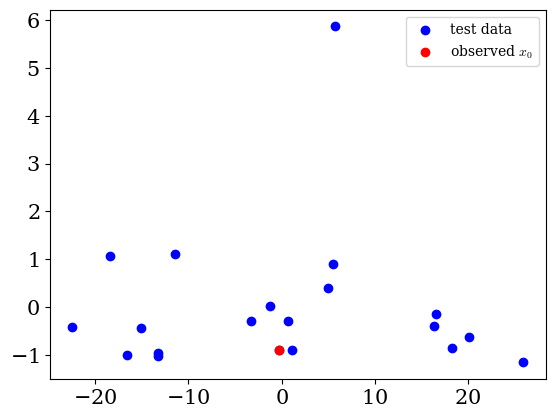

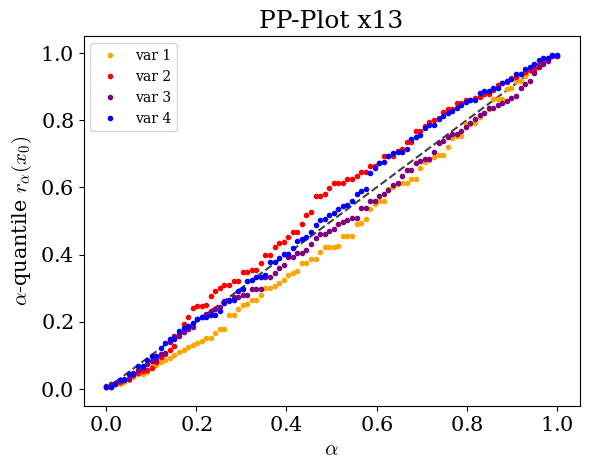

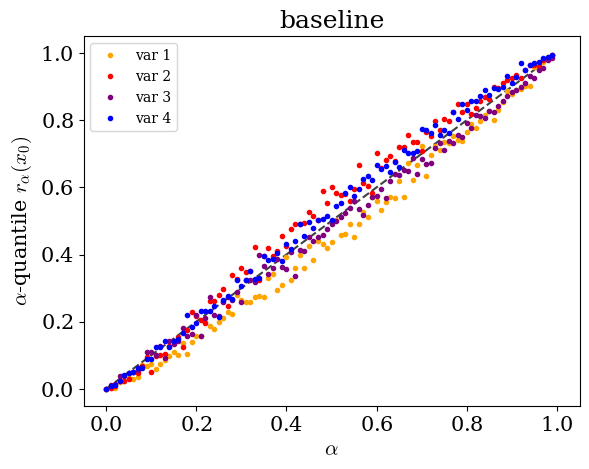

14


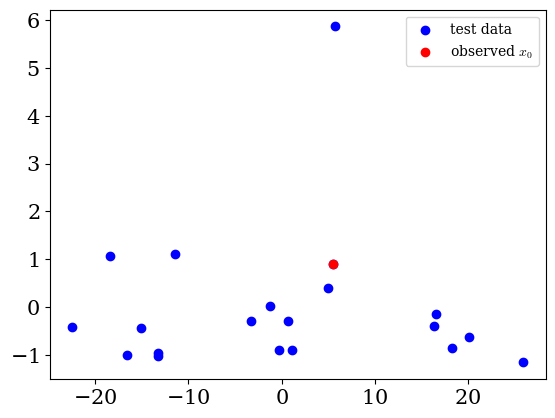

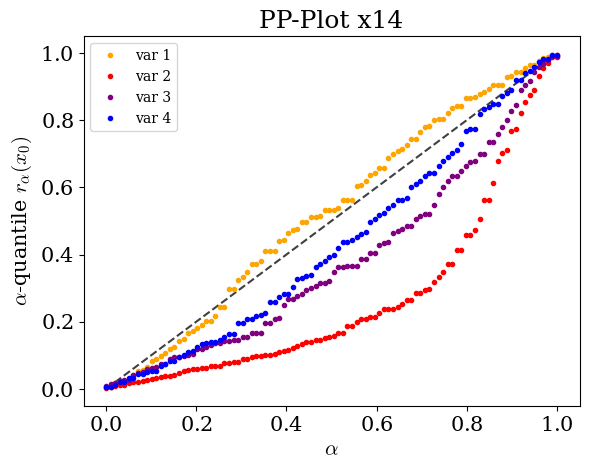

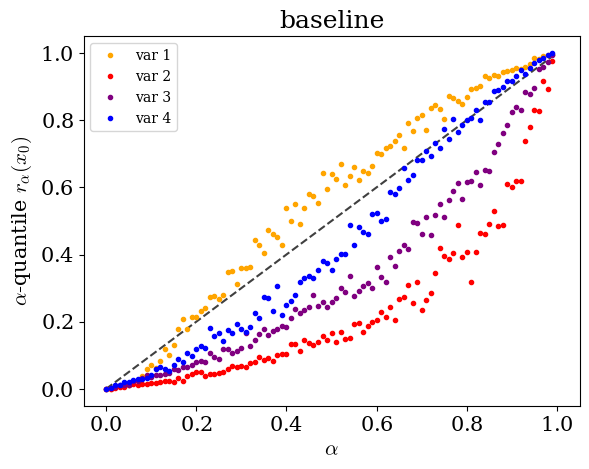

15


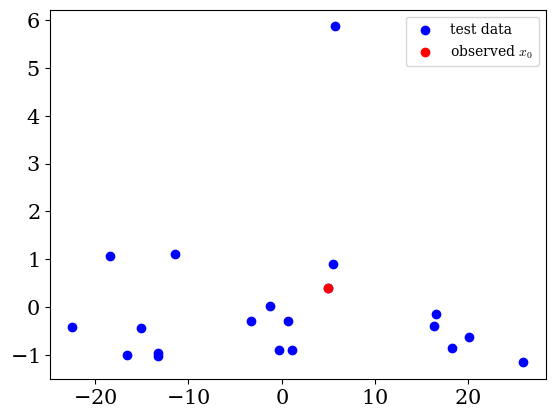

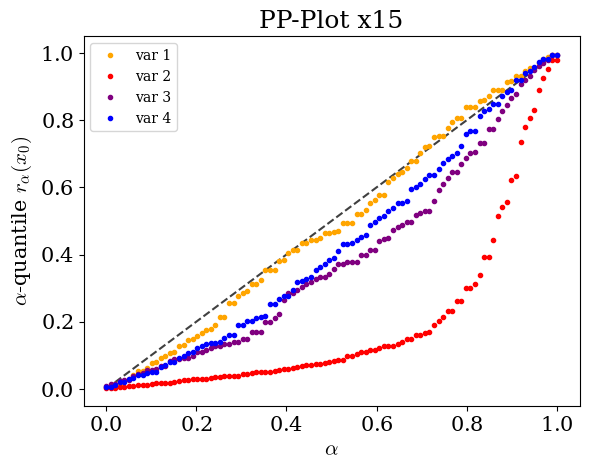

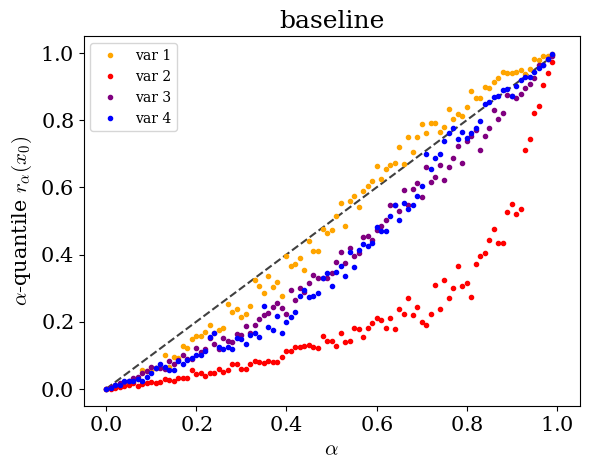

16


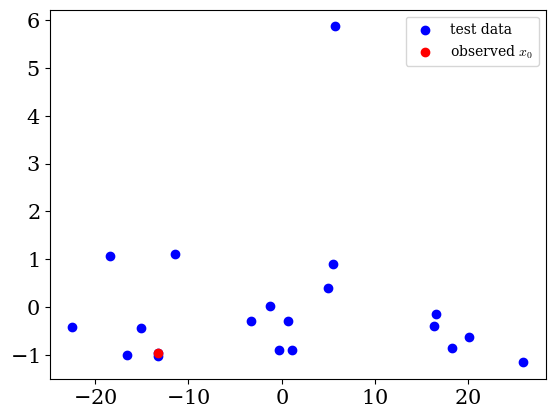

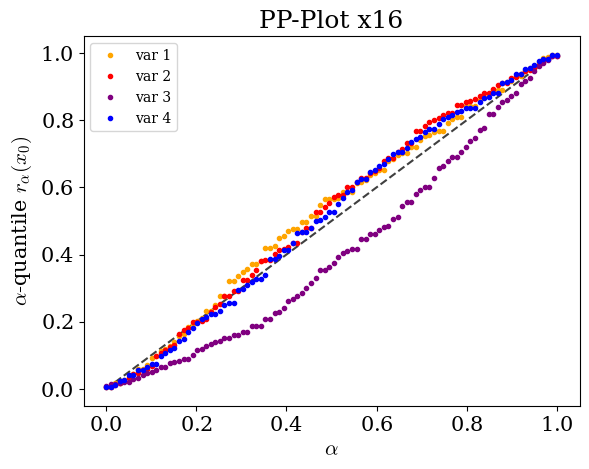

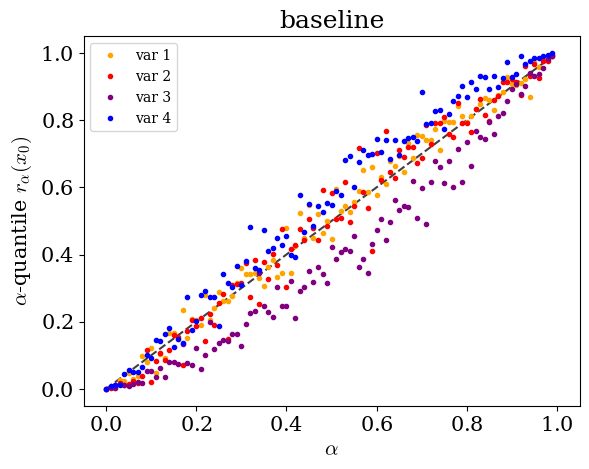

17


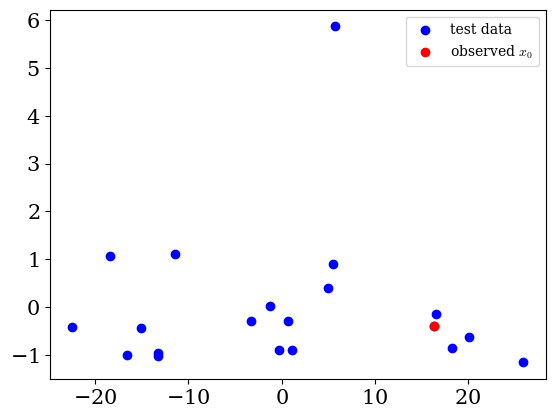

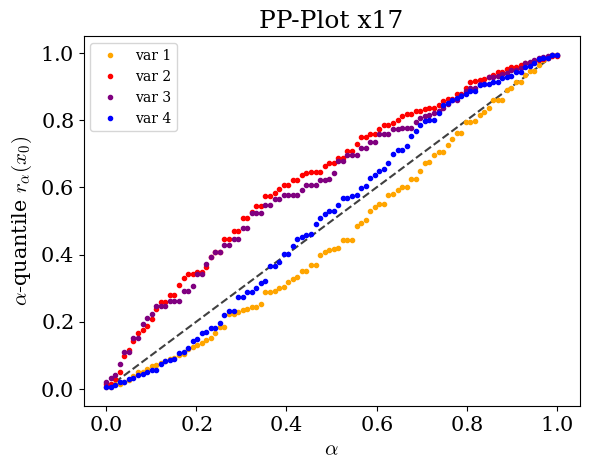

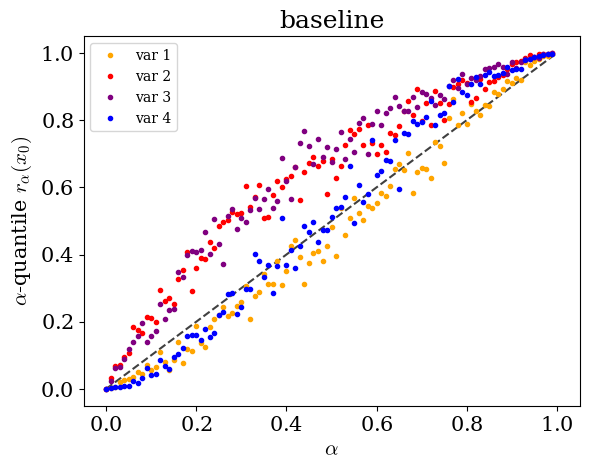

18


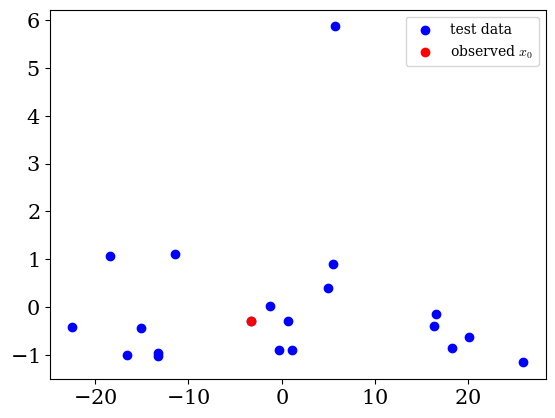

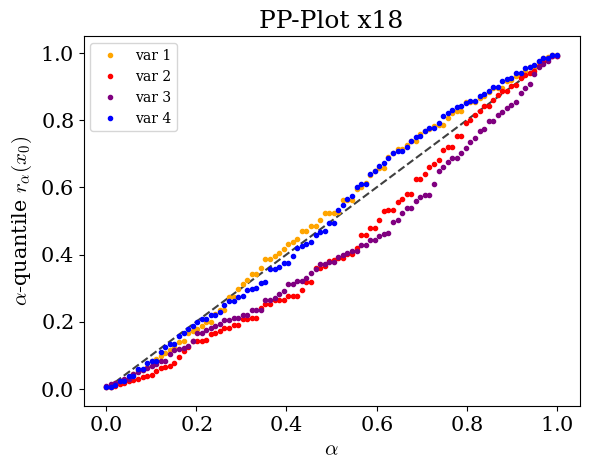

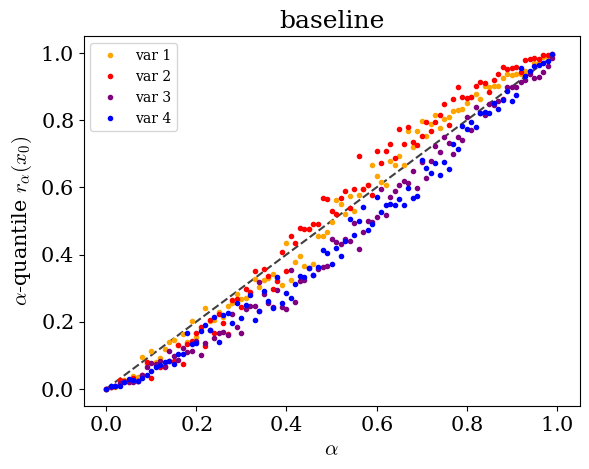

19


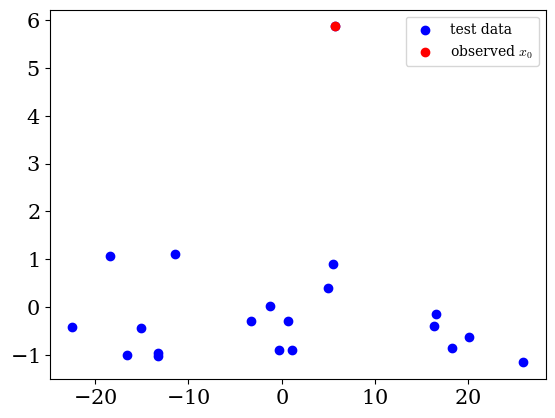

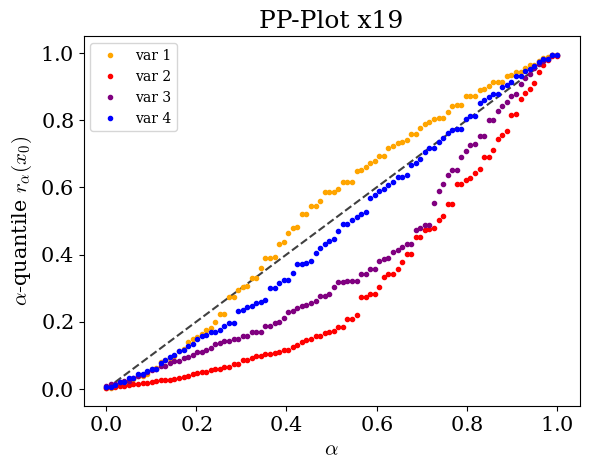

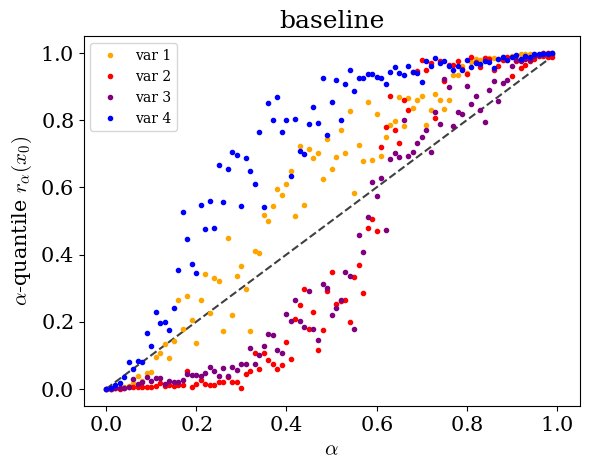

In [28]:
from scipy.stats import combine_pvalues
from sklearn.decomposition import PCA


ntrials = 1000
# path_lct = PATH_EXPERIMENT + f"pvalues/naive_nextra_{N_EXTRA}_nsim_{50000}/lct_results_ntrails_{ntrials}_n_alphas_{21}"
# path_lct_hg = PATH_EXPERIMENT + f"pvalues/naive_nextra_{N_EXTRA}_nsim_{50000}/lct_results_histgrad90_ntrails_{ntrials}_n_alphas_{21}"
# path_r_alpha = PATH_EXPERIMENT + f"r_alpha_learned/r_alpha_learned_{METHOD}_nextra_{N_EXTRA}_single_rec_{SINGLE_REC}_nsim_{B}"
# path_r_alpha_hg = PATH_EXPERIMENT + f"r_alpha_learned/r_alpha_learned_histgrad90_{METHOD}_nextra_{N_EXTRA}_nsim_{B}"

# path_lct_hg_new = PATH_EXPERIMENT+f"lct_results/naive_nextra_{N_EXTRA}_nsim_{B}/lct_results_sample50_histgrad90_ntrials_{ntrials}_n_alphas_{100}"
# path_lct_baseline = PATH_EXPERIMENT+f"lct_results/naive_nextra_{N_EXTRA}_nsim_{B}/lct_results_baseline_mlp_nalpha_100_ntrials_{ntrials}_n_alphas_{100}"

k_list = [19,18,15,14,13,10,9,17]
pca = PCA(n_components=2)
pca.fit(x_obs[:,:,0]) 
x_new = pca.transform(x_obs[:,:,0])
# plt.scatter(x_new[:,0],x_new[:,1], color='blue')

combined_pvalues = []
combined_pvalues_hg = []
for dim in range(1,5):
    for k in range(20):
        # pvalues = torch.load(path_lct+f"_pca_x{k}_new.pkl")['pvalues']
        # lct_hg = torch.load(path_lct_hg+f"_pca_x{k}_new.pkl")
        # pvalues_hg, r_alpha, r_alpha_null_list = lct_hg['pvalues'], lct_hg['r_alpha_learned'], lct_hg['r_alpha_null_list']

        lct_hg = torch.load(path_lct_hg+f"_pca_x{k}.pkl")
        lct_baseline = torch.load(path_lct_baseline+f"_pca_x{k}.pkl")
        
        # pvalues_hg, r_alpha, r_alpha_null_list = lct_hg['pvalues'], lct_hg['r_alpha_learned'], lct_hg['r_alpha_null_list']
        r_alpha = lct_hg['r_alpha_learned']
        r_alpha_baseline = lct_baseline['r_alpha_learned']
        if dim ==1:

            # COMBINED p-VALUES
            # combined_pvalues.append(combine_pvalues(list(pvalues.values()))[1])
            # combined_pvalues_hg.append(combine_pvalues(list(pvalues_hg.values()))[1])
            print(k)
            # print(f'pvalues = {pvalues_hg}')
            # print(combined_pvalues[-1])
            # print(combined_pvalues_hg[-1])

            # PCA PLOT 
            x_new_k = x_new[k]
            fig, ax = plt.subplots()
            ax.scatter(x_new[:,0],x_new[:,1], color='blue', label='test data')
            ax.scatter(x_new_k[0],x_new_k[1], color='red', label=r'observed $x_0$')
            # ax.annotate(f'pvalue = {combined_pvalues_hg[-1]}', (x_new_k[0], x_new_k[1]))
            plt.legend()
            # plt.title(f'pvalue = {combined_pvalues_hg[-1]}')
            plt.show()

            PP_plot_1D(
                PIT_values=None,
                alphas=np.linspace(0, 1, 100),
                r_alpha_learned=[
                    r_alpha["dim_1"],
                    r_alpha["dim_2"],
                    r_alpha["dim_3"],
                    r_alpha["dim_4"],
                ],
                colors=["orange", "red"],
                colors_r_alpha=["orange", "red", "purple", "blue"],
                labels=["var 1", "var 2", "var 3", "var 4"],
                title=f"PP-Plot x{k}",
            )

            # # for null hypothesis
            # PP_plot_1D(
            #     PIT_values=None,
            #     alphas=np.linspace(0, 1, 21),
            #     r_alpha_learned=[
            #         r_alpha_null_list[50]["dim_1"],
            #         r_alpha_null_list[50]["dim_2"],
            #         r_alpha_null_list[50]["dim_3"],
            #         r_alpha_null_list[50]["dim_4"],
            #     ],
            #     colors=["orange", "red"],
            #     colors_r_alpha=["orange", "red", "purple", "blue"],
            #     labels=["var 1", "var 2", "var 3", "var 4"],
            #     title=f"pvalues = {pvalues_hg}",
            # )

            # PP-PLOT BASELINE
            # on grid
            # r_alpha_learned = torch.load(path_r_alpha+f"_pca_x{k}_new.pkl")
            PP_plot_1D(
                PIT_values=None,
                alphas=np.linspace(0, 0.99, 100),
                r_alpha_learned=[
                    r_alpha_baseline["dim_1"],
                    r_alpha_baseline["dim_2"],
                    r_alpha_baseline["dim_3"],
                    r_alpha_baseline["dim_4"],
                ],
                colors=["orange", "red"],
                colors_r_alpha=["orange", "red", "purple", "blue"],
                labels=["var 1", "var 2", "var 3", "var 4"],
                title=f"baseline",
            )

